# Do *#theyknow*? Analysing Betfair market formation & market movements

---
This tutorial was written by [Tom Bishop](https://github.com/TMBish) and was [originally published on Github](https://github.com/TMBish/bfStreamTutorials/tree/main/03-market-movements/03-article). It is shared here with his permission.

This tutorial follows on logically from the [Automated betting angles in Python](../automatedBettingAnglesTutorial) we shared previously. If you're still new to working with the JSON data sets we suggest you take a look at that tutorial before diving into this one.

As always please [reach out](mailto:automation@betfair.com.au) with feedback, suggestions or queries, or feel free to submit a [pull request](https://github.com/betfair-down-under/autoHubTutorials/pulls) if you catch some bugs or have other improvements!

### Cheat sheet
- If you're looking for the complete code [head to the bottom of the page](https://betfair-datascientists.github.io/tutorials/analysingAndPredictingMarketMovements/#complete-code) or [download the script from Github](https://github.com/betfair-down-under/autoHubTutorials/blob/master/analysingAndPredictingMarketMovments/movements.ipynb).

- To run the code, save it to your machine, open a command prompt, or a terminal in your text editor of choice (we're using [VS code](https://code.visualstudio.com/download)), make sure you've navigated in the terminal to the folder you've saved the script in and then type `py main.py` (or whatever you've called your script file if not main) then hit enter. To stop the code running use Ctrl C. 

- Make sure you amend your data path to point to your data file. We'll be taking in an input of a historical tar file downloaded from the [Betfair historic data site](https://historicdata.betfair.com/#/help). We're using a PRO version, though the code should work on ADVANCED too. This approach won't work with the BASIC data tier. 

- We're using the [`betfairlightweight`](https://github.com/liampauling/betfair/tree/master/betfairlightweight) package to do the heavy lifting

- We've also posted the completed code logic on the [`betfair-downunder` Github repo](https://github.com/betfair-down-under/autoHubTutorials/tree/master/analysingAndPredictingMarketMovments).

---

## 0.0 Setup

### 0.1 Importing libraries

Once again I'll be presenting the analysis in a Jupyter notebook and will be using Python as a programming language.

Some of the data processing code takes a while to execute - that code will be in cells that are commented out - and will require a bit of adjustment to point to places on your computer locally where you want to store the intermediate data files.

You'll also need `betfairlightweight` which you can install with something like `pip install betfairlightweight`.

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import re
import csv
import plotly.express as px
import plotly.graph_objects as go
import math
import logging
import yaml
import csv
import tarfile
import zipfile
import bz2
import glob
import ast

from datetime import date, timedelta
from unittest.mock import patch
from typing import List, Set, Dict, Tuple, Optional
from itertools import zip_longest
import betfairlightweight
from betfairlightweight import StreamListener
from betfairlightweight.resources.bettingresources import (
    PriceSize,
    MarketBook
)

### 0.2 Context

You may have seen the hashtag if you're on Australian racing twitter #theyknow following a dramatic late market move for a horse that's followed by a decisive race victory. Sometimes it can seem eerie how accurate these moves are after the fact. In Betfair racing markets there's usually a flurry of activity leading up to the race start as players look to get their bets down at the best price without tipping their hand (opinion on the race) too much. Large moves can happen when large players rally around a selection who's implied chance in early trading isn't close to what it's true chance is in the upcoming race. Large moves can also happen when there's some inside information - not able to be gleaned from analysis of the horses previous races - that slowly filters out of the stable or training group.

This creates opportunity in the secondary market as punters try to read these movements to make bets themselves. The task often becomes identifying which movements are caused by these sophisticated players or represent real signals of strength and which aren't.

So do #theyknow generally? Before even looking at the data I can assure you that yes they do know pretty well. Strong movements in betting markets are usually pretty reliable indicators about what is about to happen. However, these moves can be overvalued by recreationals. When observing a horse plumet in from \$3.50 to \$2 you are usually suprised if the horse loses, but the general efficiency of late prices would suggest that this horse is going to still lose 50% of time. If you simply observe the large moves after the sharp players have corrected the market landscape you're in no better a position to bet than before the move happened. On the other hand what if would could reliably identify the move as it was happening or about to happen? That would be a recipe for successful trading of horse racing markets and no doubt this is what many players in this secondary market (analysis of Betfair markets rather than the races themselves) try to do.

If you were to build up a manual qualitative strategy for this kind of market trading you need to understand:
- Who the participants are
- How sophisticated they are at the top end
- What types of races do they bet on and for how much
- When the different types of participants typically enter the market 
- What do bet placement patterns look like for these participants
- etc.

This is the kind of task that takes a lot research, years of experience watching markets, a lot of trial and error, and a lot of industry know-how. Given I'm a lazy quantitative person I'll try to see if I can uncover any of these patterns in the data alone.

Put simply the central question for the second half of this piece will be:

> How should you think about large price moves in Betfair markets and how could you look to build secondary betting strategies by quantitatively analysing historical data

I'll just be analysing historical thoroughbred markets but the same approach could be applied to any sport or racing code of your interest.

### 0.3 This example

Building market based trading strategies is a broad and fertile ground for many quantitative Betfair customers; too big to cover in a single article. I'll try to zero in on a small slice of thoroughbred markets and analyse how these markets form and how I'd start the process of trying to find the patterns in the market movements. Again hopefully this is some inspiration for you and you can pick up some of the ideas and build them out.

Given volume of data (when analysing second by second slices of market data) I'll be looking at a year's worth of thoroughbred races from the 5 largest Victorian tracks: Flemington, Caulfield, Moonee Valley, Bendigo and Sandown.

---

## 1.0 Data

Unlike in some of the previous tutorials we aren't going to collapse the stream data into a single row per runner. In those examples we were interested in analysing some discrete things about selections in Betfair markets like:

- Their final odds (bsp or last traded price)
- Their odds at some fixed time point or time points before the scheduled race start
- Other single number descriptors of the trading activity on a selection (eg total traded volume)


In this analysis I want to analyse how markets form and prices move for selections as markets evolve. So we'll need to pull out multiple price points per runner - so we'll have multiple rows per runner in our parsed output dataset.

To output a row for every stream update for every selection in every thoroughbred race over the last 12 months would produce a dataset far too big too analyse using normal data analysis tools - we're about 10s to 100s of billions of rows.

To chop our sample down into a manageable slice I'm going to filter on some select tracks of interest (as mentioned above) and I'm also going to have 3 sections of data granularity:

- I won't log any of the odds or traded volumes > 30mins before the scheduled off
    + In thoroughbreds there is non-trivial action before this point you may want to study, but it's not what I want to study here
- Between 30 and 10 minutes before the scheduled off I'll log data every 60 seconds
- 10 minutes or less to the scheuled off I'll log prices every second

The code to manage this windowed granularity is in the below parsing code tweak as you wish if you want to tighten or broaden the analysis.

### 1.1 Sourcing data

First you'll need to source the Stream file TAR archive files. I'll be analysing 12 months of Australian thoroughbred Pro files. Ask [automation@betfair.com.au](mailto:automation@betfair.com.au) for more info if you don't know how to do this. Once you've gotten access download them to your computer and store them together in a folder.

### 1.2 Utility functions

In [2]:
# General Utility Functions
# _________________________________

def as_str(v) -> str:
    return '%.2f' % v if type(v) is float else v if type(v) is str else ''

def split_anz_horse_market_name(market_name: str) -> (str, str, str):
    parts = market_name.split(' ')
    race_no = parts[0] # return example R6
    race_len = parts[1] # return example 1400m
    race_type = parts[2].lower() # return example grp1, trot, pace
    return (race_no, race_len, race_type)


def load_markets(file_paths):
    for file_path in file_paths:
        print(file_path)
        if os.path.isdir(file_path):
            for path in glob.iglob(file_path + '**/**/*.bz2', recursive=True):
                f = bz2.BZ2File(path, 'rb')
                yield f
                f.close()
        elif os.path.isfile(file_path):
            ext = os.path.splitext(file_path)[1]
            # iterate through a tar archive
            if ext == '.tar':
                with tarfile.TarFile(file_path) as archive:
                    for file in archive:
                        yield bz2.open(archive.extractfile(file))
            # or a zip archive
            elif ext == '.zip':
                with zipfile.ZipFile(file_path) as archive:
                    for file in archive.namelist():
                        yield bz2.open(archive.open(file))

    return None

def slicePrice(l, n):
    try:
        x = l[n].price
    except:
        x = ""
    return(x)

def sliceSize(l, n):
    try:
        x = l[n].size
    except:
        x = ""
    return(x)

def pull_ladder(availableLadder, n = 5):
        out = {}
        price = []
        volume = []
        if len(availableLadder) == 0:
            return(out)        
        else:
            for rung in availableLadder[0:n]:
                price.append(rung.price)
                volume.append(rung.size)

            out["p"] = price
            out["v"] = volume
            return(out)

Slicing the tracks we want we'll just adjust the market filter function used before to include some logic on the venue name

In [3]:
def filter_market(market: MarketBook) -> bool: 
    
    d = market.market_definition
    track_filter = ['Bendigo', 'Sandown', 'Flemington', 'Caulfield', 'Moonee Valley']

    return (d.country_code == 'AU' 
        and d.venue in track_filter
        and d.market_type == 'WIN' 
        and (c := split_anz_horse_market_name(d.name)[2]) != 'trot' and c != 'pace')

### 1.3 Selection metadata

Given that the detailed price data will have so many records we will split out the selection metadata (including the selection win outcome flag and the bsp) into it's own dataset much you would do in a relational database to manage data volumes.

This means we'll have to parse over the data twice but our outputs will be much smaller than if we duplicated the selection name 800 times for example.

In [4]:
def final_market_book(s):

    with patch("builtins.open", lambda f, _: f):

        gen = s.get_generator()

        for market_books in gen():
            
            # Check if this market book meets our market filter ++++++++++++++++++++++++++++++++++

            if ((evaluate_market := filter_market(market_books[0])) == False):
                    return(None)
            
            for market_book in market_books:

                last_market_book = market_book
        
        return(last_market_book)

def parse_final_selection_meta(dir, out_file):
    
    with open(out_file, "w+") as output:

        output.write("market_id,selection_id,venue,market_time,selection_name,win,bsp\n")

        for file_obj in load_markets(dir):

            stream = trading.streaming.create_historical_generator_stream(
                file_path=file_obj,
                listener=listener,
            )

            last_market_book = final_market_book(stream)

            if last_market_book is None:
                continue 

            # Extract Info ++++++++++++++++++++++++++++++++++

            runnerMeta = [
                {
                    'selection_id': r.selection_id,
                    'selection_name': next((rd.name for rd in last_market_book.market_definition.runners if rd.selection_id == r.selection_id), None),
                    'selection_status': r.status,
                    'win': np.where(r.status == "WINNER", 1, 0),
                    'sp': r.sp.actual_sp
                }
                for r in last_market_book.runners 
            ]

            # Return Info ++++++++++++++++++++++++++++++++++

            for runnerMeta in runnerMeta:

                if runnerMeta['selection_status'] != 'REMOVED':

                    output.write(
                        "{},{},{},{},{},{},{}\n".format(
                            str(last_market_book.market_id),
                            runnerMeta['selection_id'],
                            last_market_book.market_definition.venue,
                            last_market_book.market_definition.market_time,
                            runnerMeta['selection_name'],
                            runnerMeta['win'],
                            runnerMeta['sp']
                        )
                    )

In [5]:
selection_meta = "[OUTPUT PATH TO CSV FOR SELECTION METADATA]"
stream_files = glob.glob("[PATH TO STREAM FILES]*.tar")
trading = betfairlightweight.APIClient(username = "username", password = "password", app_key="app_key")
listener = StreamListener(max_latency=None)

print("__ Parsing Selection Metadata ___ ")
# parse_final_selection_meta(stream_files, selection_meta)

__ Parsing Selection Metadata ___ 


### 1.4 Detailed preplay odds

Like mentioned above there will be some time control logic injected to control the time granularity that odds are recorded in each step.

Instead of widening the available to bet price ladder I'll extract the top 10 rungs of the available to back (atb) and available to lay (atl) ladders and write them both to the output file. That will give me more flexibility during the analysis to pull out things that interest me. So in total I'll extract:

- Top 10 ATB Ladder
- Top 10 ATL Ladder
- Total Traded Volume
- Volume weighted average traded price up till the current time
- Last Traded price

In [6]:
def loop_preplay_prices(s, o):

    with patch("builtins.open", lambda f, _: f):

        gen = s.get_generator()

        marketID = None
        tradeVols = None
        time = None

        for market_books in gen():

            # Check if this market book meets our market filter ++++++++++++++++++++++++++++++++++

            if ((evaluate_market := filter_market(market_books[0])) == False):
                    break

            for market_book in market_books:

                # Time Step Management ++++++++++++++++++++++++++++++++++

                if marketID is None:

                    # No market initialised
                    marketID = market_book.market_id
                    time =  market_book.publish_time

                elif market_book.inplay:

                    # Stop once market goes inplay
                    break

                else:
                    
                    seconds_to_start = (market_book.market_definition.market_time - market_book.publish_time).total_seconds()

                    if seconds_to_start > log1_Start:
                        
                        # Too early before off to start logging prices
                        continue

                    else:
                    
                        # Update data at different time steps depending on seconds to off
                        wait = np.where(seconds_to_start <= log2_Start, log2_Step, log1_Step)

                        # New Market
                        if market_book.market_id != marketID:
                            marketID = market_book.market_id
                            time =  market_book.publish_time
                        # (wait) seconds elapsed since last write
                        elif (market_book.publish_time - time).total_seconds() > wait:
                            time = market_book.publish_time
                        # fewer than (wait) seconds elapsed continue to next loop
                        else:
                            continue

                # Execute Data Logging ++++++++++++++++++++++++++++++++++
                                                
                for runner in market_book.runners:

                    try:
                        atb_ladder = pull_ladder(runner.ex.available_to_back, n = 10)
                        atl_ladder = pull_ladder(runner.ex.available_to_lay, n = 10)
                    except:
                        atb_ladder = {}
                        atl_ladder = {}

                    # Calculate Current Traded Volume + Tradedd WAP
                    limitTradedVol = sum([rung.size for rung in runner.ex.traded_volume])
                    if limitTradedVol == 0:
                        limitWAP = ""
                    else:
                        limitWAP = sum([rung.size * rung.price for rung in runner.ex.traded_volume]) / limitTradedVol
                        limitWAP = round(limitWAP, 2)

                    o.writerow(
                        (
                            market_book.market_id,
                            runner.selection_id,
                            market_book.publish_time,
                            limitTradedVol,
                            limitWAP,
                            runner.last_price_traded or "",
                            str(atb_ladder).replace(' ',''), 
                            str(atl_ladder).replace(' ','')
                        )
                    )




def parse_preplay_prices(dir, out_file):
    
    with open(out_file, "w+") as output:

        writer = csv.writer(
            output, 
            delimiter=',',
            lineterminator='\r\n',
            quoting=csv.QUOTE_ALL
        )
        
        writer.writerow(("market_id","selection_id","time","traded_volume","wap","ltp","atb_ladder","atl_ladder"))

        for file_obj in load_markets(dir):

            stream = trading.streaming.create_historical_generator_stream(
                file_path=file_obj,
                listener=listener,
            )

            loop_preplay_prices(stream, writer)

In [7]:
preplay_price_file =  "[OUTPUT PATH TO CSV FOR PREPLAY PRICES]"
stream_files = glob.glob("[PATH TO STREAM FILES]*.tar")


log1_Start = 60 * 30 # Seconds before scheduled off to start recording data for data segment one
log1_Step = 60       # Seconds between log steps for first data segment
log2_Start = 60 * 10  # Seconds before scheduled off to start recording data for data segment two
log2_Step = 1        # Seconds between log steps for second data segment

print("__ Parsing Detailed Preplay Prices ___ ")
# parse_preplay_prices(stream_files, preplay_price_file)

__ Parsing Detailed Preplay Prices ___ 


## 2.0 Analysis

### 2.1 Load and Assemble
First let's load the raw datafiles we created in the previous step. 
#### 2.1.1 Load
We have the highlevel selection metadata (1 row per selection):

In [8]:
selection = pd.read_csv("[PATH TO METADATA FILE]" , dtype={'market_id': object, 'selection_id': object}, parse_dates = ['market_time'])
selection.head(3)

,market_id,selection_id,venue,market_time,selection_name,win,bsp
0,1.179904683,38629713,Bendigo,2021-03-02 03:00:00,1. Bigdoorprize,0,19.37
1,1.179904683,3593031,Bendigo,2021-03-02 03:00:00,2. Cornucopia,0,6.64
2,1.179904683,38629714,Bendigo,2021-03-02 03:00:00,3. Danejararose,0,21.66


And we have the detailed preplay price data for these markets + selections:

In [9]:
prices = pd.read_csv(
    "[PATH TO PRICES FILE]", 
    quoting=csv.QUOTE_ALL,
    dtype={'market_id': 'string', 'selection_id': 'string', 'atb_ladder': 'string', 'atl_ladder': 'string'},
    parse_dates=['time']
)
prices.head(3)

,market_id,selection_id,time,traded_volume,wap,ltp,atb_ladder,atl_ladder
0,1.179904683,38629713,2021-03-01 05:15:09.480,0.0,NaN,NaN,{},{}
1,1.179904683,3593031,2021-03-01 05:15:09.480,0.0,NaN,NaN,{},{}
2,1.179904683,38629714,2021-03-01 05:15:09.480,0.0,NaN,NaN,{},{}


Now it's important to observe how much data we have here.

In [10]:
prices.shape

(7774392, 8)

We've got 7 million rows of price data here just for races at 5 thoroughbred tracks over the last year. Now it's not really "big data" in the sense you might have heard before but it's certainly a lot of rows and we'll have to think about the performance of our code a little bit more than we would if we were dealining with 1 row per selection style datasets.

We need pandas to correctly interpret the dictionary columns as dictionaries so we'll run this code:

In [11]:
# To get pandas to correctly recognise the ladder columns as dictionaries
prices['atb_ladder'] = [ast.literal_eval(x) for x in prices['atb_ladder']]
prices['atl_ladder'] = [ast.literal_eval(x) for x in prices['atl_ladder']]

#### 2.1.2 Assemble

Now we'll join the 2 data sets together to form a nice normalised dataframe:

In [12]:
# Simple join on market and selection_id initially
df = selection.merge(prices, on = ['market_id', 'selection_id'])
df.head(3)

,market_id,selection_id,venue,market_time,selection_name,win,bsp,time,traded_volume,wap,ltp,atb_ladder,atl_ladder
0,1.179904683,38629713,Bendigo,2021-03-02 03:00:00,1. Bigdoorprize,0,19.37,2021-03-01 05:15:09.480,0.00,NaN,NaN,{},{}
1,1.179904683,38629713,Bendigo,2021-03-02 03:00:00,1. Bigdoorprize,0,19.37,2021-03-02 02:30:00.552,15.95,15.44,22.0,"{'p': [18.5, 18, 17.5, 17, 16, 15, 14, 13.5, 1...","{'p': [24, 25, 29, 30, 38, 55, 65, 70, 90, 140..."
2,1.179904683,38629713,Bendigo,2021-03-02 03:00:00,1. Bigdoorprize,0,19.37,2021-03-02 02:31:06.716,15.95,15.44,22.0,"{'p': [19, 18.5, 18, 17, 16, 15, 14, 13.5, 13,...","{'p': [25, 29, 30, 38, 55, 65, 70, 90, 140, 24..."


#### 2.1.3 Transform

Next we'll do some processing on the joined dataframe to add some columns that we can use in our analysis including calculating a numeric #seconds before the scheduled jump field that we'll use extensively.

In [14]:
df = (
    df
    .assign(back_best = lambda x: [np.nan if d.get('p') is None else d.get('p')[0] for d in x['atb_ladder']])
    .assign(lay_best = lambda x: [np.nan if d.get('p') is None else d.get('p')[0] for d in x['atl_ladder']])
    .assign(back_vwap = lambda x: [np.nan if d.get('p') is None else round(sum([a*b for a,b in zip(d.get('p')[0:3],d.get('v')[0:3])]) / sum(d.get('v')[0:3]),3) for d in x['atb_ladder']])
    .assign(lay_vwap = lambda x: [np.nan if d.get('p') is None else round(sum([a*b for a,b in zip(d.get('p')[0:3],d.get('v')[0:3])]) / sum(d.get('v')[0:3]),3) for d in x['atl_ladder']])
    .assign(seconds_before_scheduled_jump = lambda x: round((x['market_time'] - x['time']).dt.total_seconds()))
    .query('seconds_before_scheduled_jump < 1800 and seconds_before_scheduled_jump > -120')
)

### 2.2 Market formation

Before we analyse how prices for selections move let's understand some basic things about how thoroughbred markets form.

#### 2.2.1 Traded Volumes

Let's look at how a typical market (at one of these 5 tracks) trades leading up to the scheduled race start.

To make some of the analysis a little bit cleaner we need to pad out missing odds updates. For example for a given market we might have a market update 140 seconds before the jump but not another one till 132 seconds before the jump. We'll add rows for those interim 8 seconds by filling the values from the the previous row, this is required to iron out some idiosyncracies in the aggregations, it's not that important to follow if you don't understand it.

In [ ]:
traded_volume_values = df[['market_id', 'selection_id', 'venue', 'bsp', 'seconds_before_scheduled_jump', 'traded_volume']]
all_sbj = pd.DataFrame(data = {'seconds_before_scheduled_jump': traded_volume_values.seconds_before_scheduled_jump.unique()}).assign(join = 1)
traded_volume_explode = traded_volume_values[['market_id', 'selection_id', 'venue', 'bsp']].drop_duplicates().assign(join = 1).merge(all_sbj).drop('join', 1)
traded_volume_df = traded_volume_explode.merge(traded_volume_values, how = "left")
traded_volume_df = traded_volume_df.sort_values(['market_id', 'selection_id', 'venue', 'seconds_before_scheduled_jump'], ascending=[True, True, True, False])
traded_volume_df.update(traded_volume_df.groupby(['market_id', 'selection_id', 'venue'])[['seconds_before_scheduled_jump', 'traded_volume']].ffill().fillna(0))

/tmp/ipykernel_327971/677704215.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



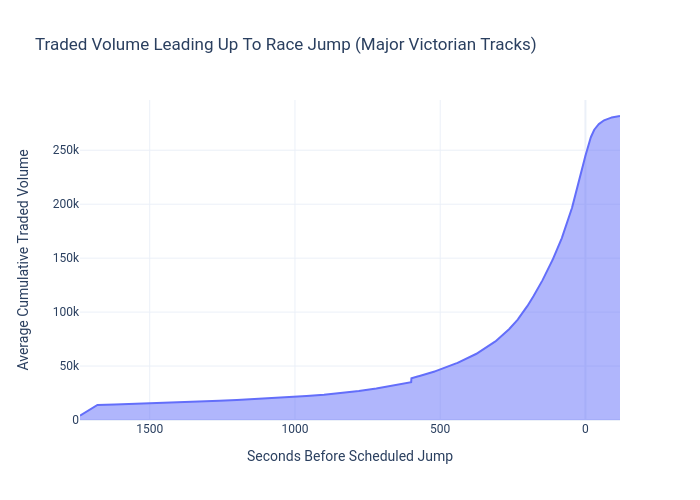

In [ ]:
# Group by market, sum volume over selections at a given time, average over times for total
def chunkSBJ(sbj):
    if sbj < 600:
        return(sbj)
    else:
        return(int(math.floor(sbj / 60) * 60))

tradedVolumes_1 = (
    traded_volume_df
    .groupby(["market_id", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'traded_volume': 'sum'})
    .assign(seconds_before_scheduled_jump = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .groupby("seconds_before_scheduled_jump", as_index = False)
    .agg({'traded_volume': 'mean'})
    .sort_values('seconds_before_scheduled_jump', ascending=False)
)

fig = px.area(
    tradedVolumes_1, 
    x='seconds_before_scheduled_jump', y='traded_volume', 
    template='plotly_white',
    title="Traded Volume Leading Up To Race Jump (Major Victorian Tracks)",
    labels = {
        'seconds_before_scheduled_jump': "Seconds Before Scheduled Jump",
        "traded_volume": "Average Cumulative Traded Volume"
    }
    #subtitle = "Top 5 Biggest Vic Track Sample"
)
fig.update_layout(font_family="Roboto")
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show("png")

The discontinuity in the chart highlights the switch point between the two time granularities that we extracted from the stream. Pre 600 seconds (10 minutes) before the scheduled off I can plot 1 data point per minute and after I'm plotting 60 data points per minute.

The traded volume chart looks like an exponential chart: the total traded volume doubles from 10 minutes out to 4 minutes out, then it doubles again between then and 1 minute out, then nearly doubling again in the last minute and a bit of trading. Even a simple visual like this can help you with your bet placement on Betfair markets. For example if you're planning to get large volumes down on Betfair thoroughbred markets it's probably best to view prices >10 minutes out with a skeptical eye even if the market is tight - because you won't find the requisite lay volume that early as the majority of traded volume happens in the last 2-5 minutes of trading.

Now like most analysis the average is definitely hiding lots of interesting things about this data. Let's split out this data by our 5 tracks:

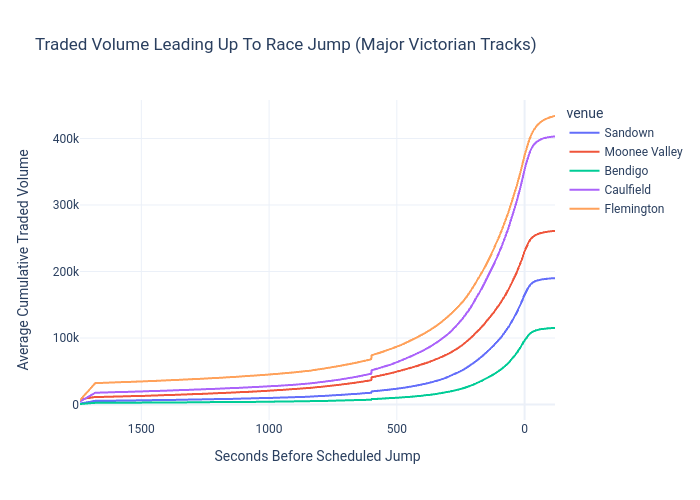

In [ ]:
tradedVolumes_2 = (
   traded_volume_df
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .groupby(["market_id", "venue", "seconds_before_scheduled_jump_chunk", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'traded_volume': 'sum'})
    .groupby(["venue", "seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'traded_volume': 'mean'})
    .sort_values('seconds_before_scheduled_jump_chunk', ascending=False)
)

fig_2 = px.line(
    tradedVolumes_2, 
    x='seconds_before_scheduled_jump_chunk', y='traded_volume',  color='venue',
    template='plotly_white',
    title="Traded Volume Leading Up To Race Jump (Major Victorian Tracks)",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "traded_volume": "Average Cumulative Traded Volume"
    }
)
fig_2.update_layout(font_family="Roboto")
fig_2['layout']['xaxis']['autorange'] = "reversed"
fig_2.show("png")

As expected an average Flemington race trades nearly 500k whereas an average Bendigo race trades only ~120k volume.

How about if we split our selections by odds range. Intuitively we know that odds-on horses will trade significantly more volume than a \$50 shot but let's visualise the difference.

We'll chunk the BSP of each horse into 5 groups:
- Odds on (<50% chance of winning)
- Odds between 2 and 5
- Odds between 5 and 15
- Odds between 15 and 50
- Odds 50+

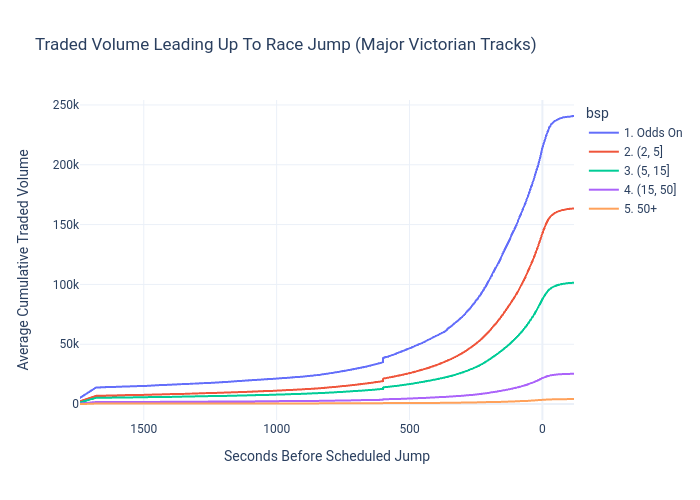

In [ ]:
def chunkBsp(bsp):
    if bsp <= 2:
        return("1. Odds On")
    elif bsp <= 5:
        return("2. (2, 5]")
    elif bsp <= 15:
        return("3. (5, 15]")
    elif bsp <= 50:
        return("4. (15, 50]")
    else:
        return("5. 50+")

# Group by odds range
tradedVolumes_3 = (
    traded_volume_df
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(bsp = lambda x: x['bsp'].apply(chunkBsp))
    .groupby(["market_id", "bsp", "seconds_before_scheduled_jump_chunk", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'traded_volume': 'sum'})
    .groupby(["bsp", "seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'traded_volume': 'mean'})
)

fig_3 = px.line(
    tradedVolumes_3, 
    x='seconds_before_scheduled_jump_chunk', y='traded_volume', color='bsp',
    template='plotly_white',
    title="Traded Volume Leading Up To Race Jump (Major Victorian Tracks)",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "traded_volume": "Average Cumulative Traded Volume"
    }
)
fig_3.update_layout(font_family="Roboto")
fig_3['layout']['xaxis']['autorange'] = "reversed"
fig_3.show("png")

Again as expected the traded volume is strongly inversely proportional to the implied chance. There's a few reasons for this: 
- Inherently exposure is inversely proportional to odds so the same stake can produce widely different exposures for lay betting
- Non model based participants have limited resources to manually analyse the form and thus focus on the top end of the market
- Higher chance events reduce variance which is captured in staking schemes like the kelly criterion (which overweight stakes on larged percieved advantages on high probability events) that sophisticated participants tend to use

Knowing where a majority of the traded volume is concentrated is another thing you should be aware of whether your betting on horse racing or elections and everything in between.

#### 2.2.2 Market Tightness

Understanding how the market tightens before the off is also another key conceptual component to market formation. I will consider two different variations on this concept:

- Market overround or Market Percentage
    + The sum of probabilities across all outcomes
    + Back % are always above 1 (else there exists an arbitrage opportunity)
    + Lay % are always below 1 (else there exists an arbitrage opportunity)
- Market Spread
    + The # of ticks / rungs between the best available back price and the best available lay price

The market % is the value displayed on the Betfair website here:

![overround](../img/img2/overround.png)

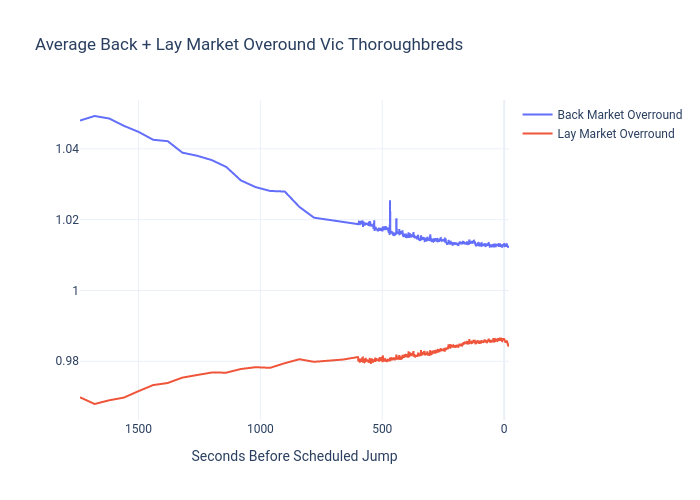

In [18]:
averageMarketPct = (
    df[['market_id', 'selection_id', 'seconds_before_scheduled_jump', 'back_best', 'lay_best']]
    .query('seconds_before_scheduled_jump >= -20')
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(
        back_best = lambda x: 1 / x['back_best'],
        lay_best = lambda x: 1 / x['lay_best']
    )
    .groupby(["market_id", "seconds_before_scheduled_jump_chunk", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'back_best': 'sum', 'lay_best': 'sum'})
    .groupby("seconds_before_scheduled_jump_chunk", as_index = False)
    .agg({'back_best': 'mean', 'lay_best': 'mean'})
    .sort_values('seconds_before_scheduled_jump_chunk', ascending=False)
)

fig_4 = go.Figure()
fig_4.add_trace(go.Scatter(x=averageMarketPct['seconds_before_scheduled_jump_chunk'], y=averageMarketPct['back_best'],
                    mode='lines',
                    name='Back Market Overround'))
fig_4.add_trace(go.Scatter(x=averageMarketPct['seconds_before_scheduled_jump_chunk'], y=averageMarketPct['lay_best'],
                    mode='lines',
                    name='Lay Market Overround'))
fig_4.update_layout(
    font_family="Roboto", 
    template="plotly_white",
    title='Average Back + Lay Market Overound Vic Thoroughbreds'
)
fig_4.update_xaxes(title = "Seconds Before Scheduled Jump")
fig_4['layout']['xaxis']['autorange'] = "reversed"
fig_4.show("png")

As you can see the back and lay market % converge to 1 as the market gets closer to the jump. However, these are generally great markets even 30 mins before the off to have overrounds of only 4% is very good for racing markets. 

If you were analysing different kinds of racing markets, however, (harness or greyhound markets or thoroughbred races for country meets) you may need to conduct this kind of analysis to see when the earliest time you're likely to be able to get fair prices on either side of the market.

Another way we can measure the tightness of Betfair markets is the market spread. I'm going to define the market spread as the number of ticks between the best back and best lay prices. This can give some extra granularity when measuring the market tightness for an individual selection

![market_spread](../img/img2/market-spread.png)

In this market for example we can see that the first selection has a spread of 5 ticks between 11 and 13.5 (where ticks are 0.5 apart) whereas there's only 2 ticks between the best back and lay for the market favourite 3.4 and 3.5 (where ticks are 0.05 apart).

First we'll need to create some custom functions that will create the Betfair ladder and do Betfair "tick arithmetic" for us. Part of the reason that I'm creating a different view for market spread is as a reason to introduce this Betfair tick ladder concept. Measuring odds differences and movement between odds values can be tricky because prices are fairly non-linear in probability space (you see far more horses between 2 and 3 than you do between 802 and 803 for example). Converting prices to a rank on the Betfair tick ladder creates a nice output mapping that can be used for all kinds of other purposes. Betfair actually has some [Betfair arithmetic tick functions](https://github.com/betfair-down-under/ticks) available on Github

In [19]:
# Define the betfair tick ladder
def bfTickLadder():

    tickIncrements = {
        1.0: 0.01,
        2.0: 0.02,
        3.0: 0.05,
        4.0: 0.1,
        6.0: 0.2,
        10.0: 0.5,
        20.0: 1.0,
        30.0: 2.0,
        50.0: 5.0,
        100.0: 10.0,
        1000.0: 1000,
    }

    ladder = []

    for index, key in enumerate(tickIncrements):

        increment = tickIncrements[key]

        if (index+1) == len(tickIncrements):
            ladder.append(key)
        else:
            key1 = [*tickIncrements][index]
            key2 = [*tickIncrements][index+1]
            steps = (key2 - key1) / increment

            for i in range(int(steps)):
                ladder.append(round(key + i * increment, 2))

    return(ladder)

bfticks = bfTickLadder()
    
# Round a decimal to the betfair tick value below
def bfTickFloor(price, includeIndex=False):

    if 'bfticks' in globals():
        global bfticks
    else:
        bfticks = bfTickLadder()

    ind = [ n for n,i in enumerate(bfticks) if i>=price][0]
    if includeIndex:
        if bfticks[ind]==price:
            return((ind, price))
        else:
            return((ind-1, bfticks[ind-1]))
    else:
        if bfticks[ind]==price:
            return(price)
        else:
            return(bfticks[ind-1])

# Calculate the numder of ticks between two tick values
def bfTickDelta(p1, p2):

    if np.isnan(p1) or np.isnan(p2):
        return(np.nan)

    x = bfTickFloor(p1, includeIndex=True)
    y = bfTickFloor(p2, includeIndex=True)
    return(x[0]-y[0])

In [20]:
bfTickDelta(13.5, 11)

5

In [21]:
bfTickDelta(3.5, 3.4)

2

Now that we have our functions let's plot the average market spread leading up to the jump.

In [22]:
# Group by odds range
averageMarketSpread = (
    df[['market_id', 'selection_id', 'seconds_before_scheduled_jump', 'back_best', 'lay_best']]
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(market_spread = lambda x: x.apply(lambda x: bfTickDelta(x.lay_best, x.back_best), axis=1))
    .groupby(["seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'market_spread': 'mean'})
)

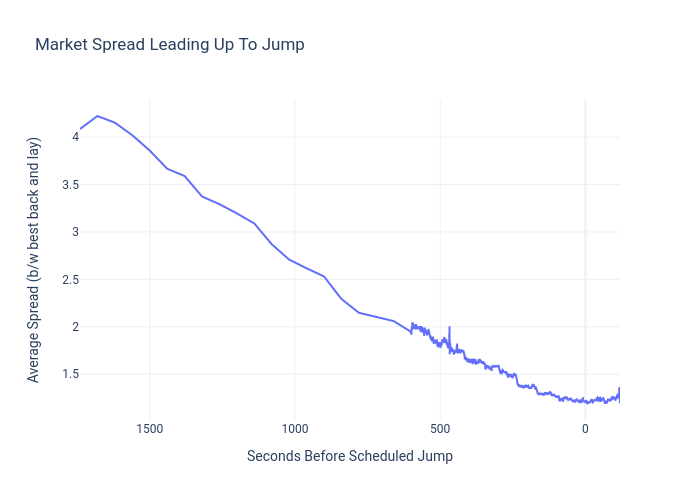

In [23]:

fig_5 = px.line(
    averageMarketSpread, 
    x='seconds_before_scheduled_jump_chunk', y='market_spread',
    template='plotly_white',
    title="Market Spread Leading Up To Jump",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "market_spread": "Average Spread (b/w best back and lay)"
    }
)
fig_5.update_layout(font_family="Roboto")
fig_5['layout']['xaxis']['autorange'] = "reversed"
fig_5.show("png")

So much the same story as before, the spread tightens pretty dramatically leading all the way up to the jump. Now that we have a measure for market tightness on a selection level we can split it by odds range to see how tightness varies across odds range.

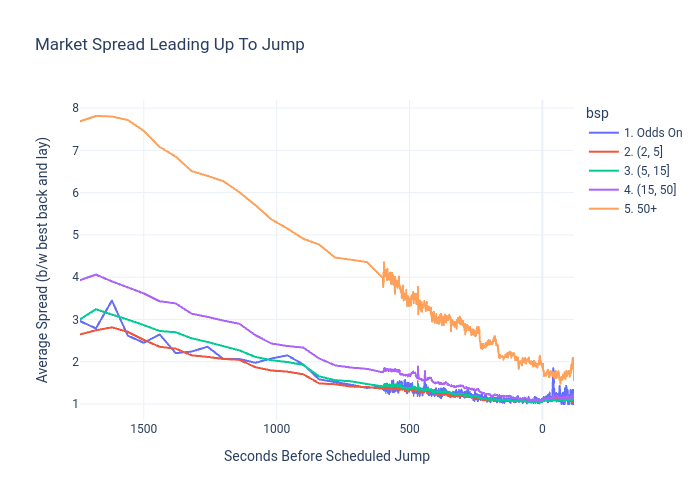

In [24]:
# Market Spread By Odds Group
# _______________________

# Group by odds range
averageMarketSpreadOddsgrp = (
    df[['market_id', 'selection_id', 'bsp','seconds_before_scheduled_jump', 'back_best', 'lay_best']]
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(bsp = lambda x: x['bsp'].apply(chunkBsp))
    .assign(market_spread = lambda x: x.apply(lambda x: bfTickDelta(x.lay_best, x.back_best), axis=1))
    .groupby(["bsp", "seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'market_spread': 'mean'})
)

fig_6 = px.line(
    averageMarketSpreadOddsgrp, 
    x='seconds_before_scheduled_jump_chunk', y='market_spread', color = "bsp",
    template='plotly_white',
    title="Market Spread Leading Up To Jump",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "market_spread": "Average Spread (b/w best back and lay)"
    }
)
fig_6.update_layout(font_family="Roboto")
fig_6['layout']['xaxis']['autorange'] = "reversed"
fig_6.show("png")

Now this gives us visibility of how the market tightens across groups of selections. Clearly the bottom end of the market takes a bit longer to tighten up which fits our understanding that there's generally less money, and less very sharp money on these selections.

### 2.3 Market Moves

Circling back to the motivation of this article: 

> How should you think about large price moves in Betfair markets and how could you look to build secondary betting strategies by quantitatively analysing historical data

Now that we have a good grasp on the data we've collected on how Betfair markets form let's try to analyse big price moves. Here's a sample of our largest price moves in our race sample:



In [25]:
# Big Movers
# ____________________

(
    df
    .groupby(['market_id', 'selection_id', 'venue', 'selection_name', 'win', 'bsp'], as_index = False)
    .agg({'ltp': 'max'})
    .rename(columns = {'ltp': 'max_traded'})
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.max_traded, x.bsp), axis=1))
    .query('max_traded < 500')
    .sort_values('ticks_in', ascending = False)
    .head(10)
)

,market_id,selection_id,venue,selection_name,win,bsp,max_traded,ticks_in
9209,1.182760338,39317622,Bendigo,6. San Fabrizio,0,2.81,10.50,71
2277,1.173069469,35981261,Bendigo,13. Shotmaker,1,2.32,4.20,56
4853,1.176708684,37456112,Bendigo,6. Zoutons,1,1.94,3.00,56
7795,1.180291241,38744938,Sandown,4. Summit Reach,0,2.42,4.50,54
4404,1.175952680,36995397,Bendigo,2. Nikau Spur,0,1.68,2.40,52
6413,1.178722039,27445196,Sandown,6. Miss Five Hundred,0,2.05,3.20,52
10216,1.184305249,39800435,Sandown,18. Lucabelle,0,48.00,470.00,48
5872,1.177927858,38197699,Flemington,2. Long Arm,0,9.90,80.00,47
1519,1.172217104,35609408,Moonee Valley,4. Tailleur,1,1.61,2.14,46
8856,1.182235083,25370687,Bendigo,3. Cernan,0,2.34,3.65,46


Some of those moves are astounding: San Fabrizio traded at 10.50 in the last 30 mins before the jump and had a final BSP of 2.80, but lost. 

Like we discussed before observing a market plunge in hindsight may seem like a more powerful predictor than it actually is. For example, if we had have flat staked these 10 giant moves after they happened (say at the BSP) we'd be running at ~70% POT even though our intuition would have told you at the time that these horses couldn't lose!

#### 2.3.1 Reacting to moves after they happen

Bookies, race callers and other services will often tell you what selection has been strong in the market; who the "money" has come for. But once you hear this is it already too late to do anything about?

Let's extend the sample in the previous section to see if we can draw any broader conclusions.

- I'll take a sample of the all selections 10 minutes before the scheduled jump
- I'll also take those same selections at the scheduled jump exactly
- I'll then calculate the number of ticks between the best back price at each time point to measure the movement in the last 10 minutes of trading
- I'll then calculate a back and lay profit using the top box at the scheduled off

In [26]:
m10 = (
    df
    .groupby(['market_id', 'selection_id'], as_index = False)
    .apply(lambda g: None if g[g['seconds_before_scheduled_jump'] < 600].shape[0] == 0 else g[g['seconds_before_scheduled_jump'] < 600].sort_values('seconds_before_scheduled_jump', ascending = False).iloc[0])
    .filter(items = ['market_id', 'selection_id', 'venue', 'selection_name', 'win', 'back_best', 'lay_best'])
    .rename(columns = {'back_best': 'back_best_10m', 'lay_best': 'lay_best_10m'})
)

m0 = (
    df
    .groupby(['market_id', 'selection_id'], as_index = False)
    .apply(lambda g: None if g[g['seconds_before_scheduled_jump'] < 0].shape[0] == 0 else g[g['seconds_before_scheduled_jump'] < 0].sort_values('seconds_before_scheduled_jump', ascending = False).iloc[0])
    .filter(items = ['market_id', 'selection_id', 'venue', 'selection_name', 'win', 'back_best', 'lay_best'])
)

In [27]:
# Back or lay according to large plunges
pd.DataFrame( 
    m10.merge(m0)
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_10m, x.back_best), axis=1))
    .query('ticks_in >= 15')
    .assign(back_pl = lambda x:  np.where(x['win'] == 1, 0.95 * (x['back_best']-1), -1))
    .assign(lay_pl = lambda x:  np.where(x['win'] == 1, -1*(x['lay_best']-1), 0.95))
    .assign(stake = 1)
    .agg({'stake': 'sum', 'back_pl': 'sum', 'lay_pl': 'sum'})
)

,0
stake,241.000
back_pl,-4.824
lay_pl,-17.620


In [28]:
# Back or lay according to large plunges - grouped by track
( 
    m10.merge(m0)
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_10m, x.back_best), axis=1))
    .query('ticks_in >= 15')
    .assign(back_pl = lambda x:  np.where(x['win'] == 1, 0.95 * (x['back_best']-1), -1))
    .assign(lay_pl = lambda x:  np.where(x['win'] == 1, -1*(x['lay_best']-1), 0.95))
    .assign(stake = 1)
    .groupby('venue', as_index = False)
    .agg({'stake': 'sum', 'back_pl': 'sum', 'lay_pl': 'sum'})
)

,venue,stake,back_pl,lay_pl
0,Bendigo,73,-14.7225,8.64
1,Caulfield,32,21.1305,-25.20
2,Flemington,36,-8.0095,5.13
3,Moonee Valley,34,-18.8730,16.62
4,Sandown,66,15.6505,-22.81


As you can see there's not much of a pattern here to take advantage of here. At least for this sample of tracks, and for this time slice, the value has been sucked dry from the market on these selections. 
To illustrate this let's check what the backers would have profited if they were the ones who could identify these selections prior to their big market moves

In [29]:
# Backing before the plunge?
( 
    m10.merge(m0)
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_10m, x.back_best), axis=1))
    .query('ticks_in >= 15')
    .assign(back_pl = lambda x:  np.where(x['win'] == 1, 0.95 * (x['back_best_10m']-1), -1))
    .assign(lay_pl = lambda x:  np.where(x['win'] == 1, -1*(x['lay_best_10m']-1), 0.95))
    .assign(stake = 1)
    .agg({'stake': 'sum', 'back_pl': 'sum', 'lay_pl': 'sum'})
)

stake      241.0000
back_pl    108.6155
lay_pl    -154.6100
dtype: float64

I could sign up for winning at 50% POT! Now I just have to pick 100% of the large thoroughbred plunges before they happen... Obviously no one individual person or group is predicting these movements 100%. Even the sharpest players will have movements go against them but this highlights the essence of the problem and the contradiction of retrospective price movement analysis.

These movements are important. There is a lot to be gained by purely trading Betfair markets and how they move. However, identifting large moves **after** they occur isn't good enough. The large players sharpen the odds down to a good and fair implied chance and leave those watching on the sidelines with little to no value either side. To profit then we must capture some of the value as they are and jump on momentum as it's happening not after it's come to a halt.

#### 2.3.2 Visualising the moves

In the final section I'll frame how I think you could go about identifying these moves as they're happening or about to happen. But first to illustrate some of dynamics let's visualise some of these large moves. How do selections firm and do they do it with different characteristics in different patterns? Candlestick charts are a good way to visualise the evolution of prices in markets and are often used in financial markets to do technical analysis.

I'll first create a function to create a candlestick chart for a market / selection slice of our dataframe using plotly charts.


In [32]:
# Candlestick Plotly Chart With Plotly
# _____________________________

def priceCandlestickPlotly(d):

    d['time_chunk'] = d['time'].dt.round('2min')  

    selectionName = d.selection_name.iloc[0]
    track = d.venue.iloc[0]
    startTime = d.market_time.iloc[0]

    candleStickInput = d.groupby('time_chunk', as_index=False).agg({"ltp": ['first', 'last', 'min', 'max']})

    candleStickInput.columns = ["_".join(pair) for pair in candleStickInput.columns]

    fig = go.Figure(data=[go.Candlestick(x=candleStickInput['time_chunk_'],
                    open=candleStickInput['ltp_first'],
                    high=candleStickInput['ltp_max'],
                    low=candleStickInput['ltp_min'],
                    close=candleStickInput['ltp_last'])])
    fig.update_layout(
        template="plotly_white", 
        xaxis_rangeslider_visible=False,
        title=f'{selectionName} at {track} race started at {startTime} UTC'
    )
    fig.show("png")

Let's visualise the 2 biggest moves with this chart function.

/home/tmbish/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



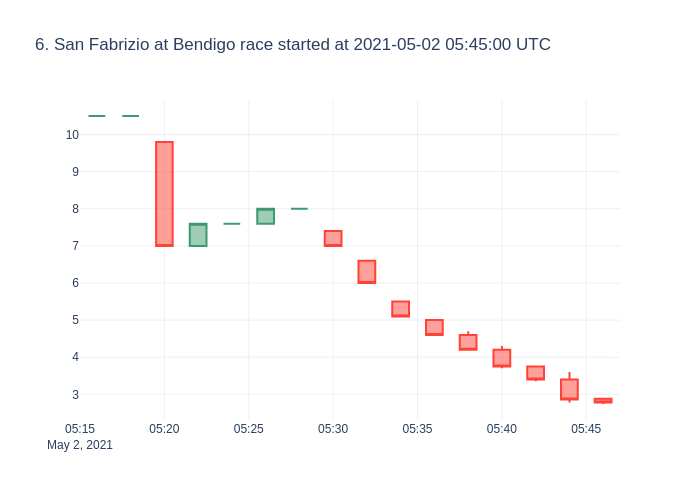

In [33]:
priceCandlestickPlotly(df.query('market_id == "1.182760338" and selection_id == "39317622"'))

This looks exactly like what we'd expect from a extreme plunge: consistent, sustained and unrelenting support on the back side as the horse is pushed from 8-10 odds down to it's fair odds of around 3.

Let's look at the second big plunge:

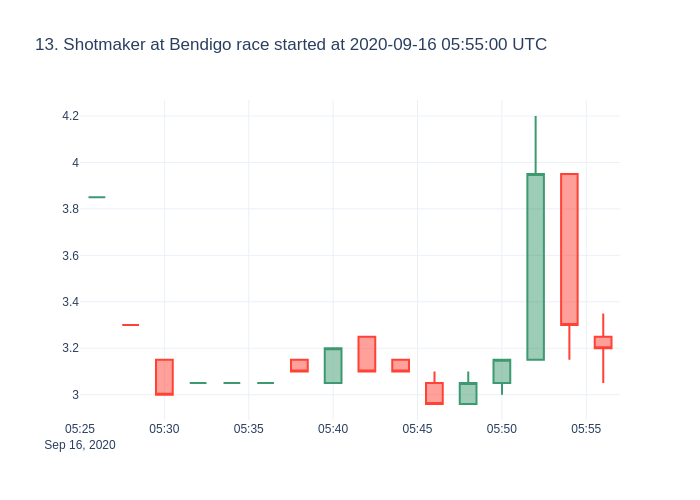

In [34]:
priceCandlestickPlotly(df.query('market_id == "1.173069469" and selection_id == "35981261"'))

This movement chart is a bit different. The market has 4 distinct segments:

- About 30 minutes from the off the market changes and the horse is supported from 4 into 3
- It trades at around 3 for the next 25 minutes
- It then drifts back out sharply to a bit over 4
- It then gets crunched back in all the way into a BSP of 2.30

Clearly different segments of the participants had very different perceptions of this horses chances. How do we make sense of it?

Let's try a different candlestick visualistion, which includes the traded volume.

In [35]:
import mplfinance as fplt

def priceCandlestickMpl(d):

    d['time_chunk'] = d['time'].dt.round('2min')  

    selectionName = d.selection_name.iloc[0]
    track = d.venue.iloc[0]
    startTime = d.market_time.iloc[0]

    # Add traded volume in last interval
    d = d.groupby(['market_id', 'selection_id']).apply(lambda x: x.assign(traded_volume_delta = lambda y: (y['traded_volume'] - y['traded_volume'].shift(1)).mask(pd.isnull, 0)))

    candleStickInput = d.groupby('time_chunk', as_index=False).agg({"ltp": ['first', 'last', 'min', 'max'], "traded_volume_delta": 'sum'})

    candleStickInput.columns = ["_".join(pair) for pair in candleStickInput.columns]

    candleStickInput = candleStickInput.rename(columns = {'time_chunk_': 'date','ltp_first': 'open', 'ltp_last': 'close', 'ltp_min': 'low', 'ltp_max': 'high', 'traded_volume_delta_sum': 'volume'})

    candleStickInput = candleStickInput.set_index('date')

    fplt.plot(
        candleStickInput,
        type='candle',
        style='yahoo',
        title= f'{selectionName} at {track} race started at {startTime} UTC',
        ylabel='Odds',
        volume=True,
        ylabel_lower='Volume Traded',
    )

First the first horse:

/home/tmbish/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



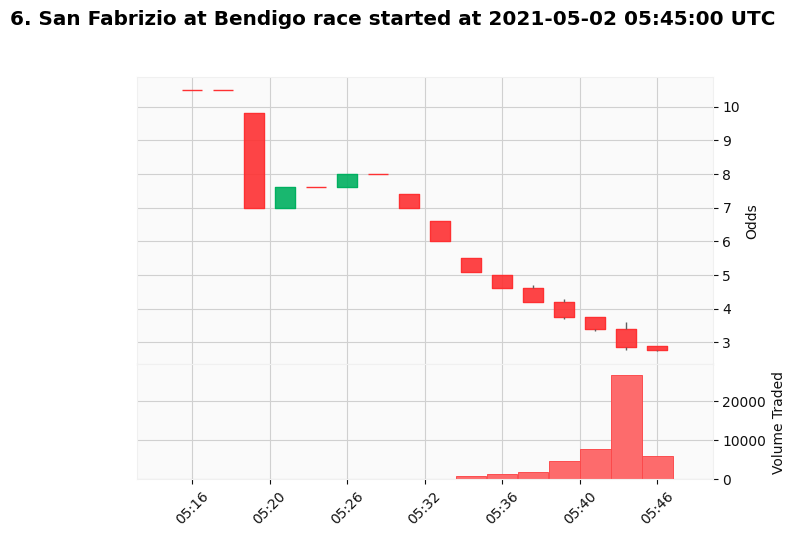

In [36]:
priceCandlestickMpl(df.query('market_id == "1.182760338" and selection_id == "39317622"'))

Now the second selection:

/home/tmbish/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



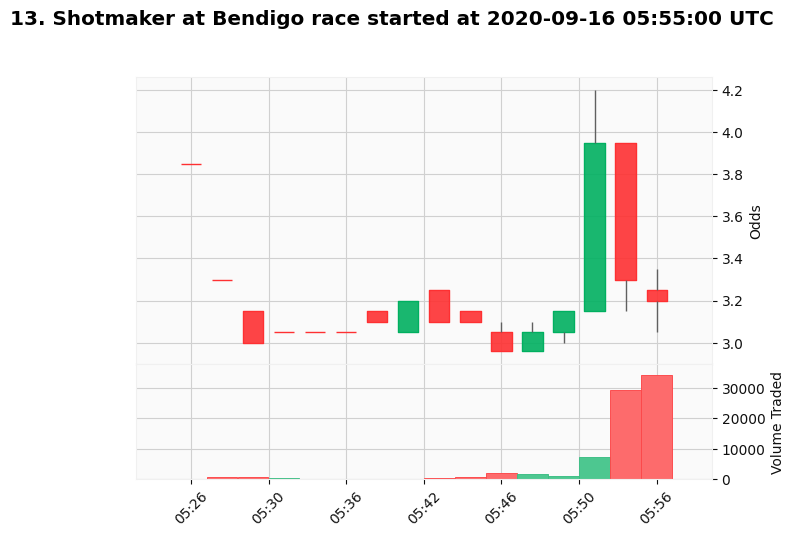

In [37]:
priceCandlestickMpl(df.query('market_id == "1.173069469" and selection_id == "35981261"'))

So as the majority of the volume was traded right before the jump, the price was hammered into 2.30. This is a pattern that you might see a lot in Betfair markets: prices may oscillate around or even drift consistently in one direction until a point at which certain large participants or groups of participants enter the market and push the selection in another direction completely.

So anticipating a move won't be as simple as analysing the price as a time series, it's one piece of the puzzle. Really sophisticated market trading algorithms will need to historically analyse a raft of market metrics and correlate them with these movements historically within the market type of interest. In the next section I'll start off down that road to give you an idea of how I'd tackle the problem but it's more complicated than we can uncover in a single article.

#### 2.3.3 Anticipating a move

Our retrospective analysis was good to help us understand the dynamics of movements, the efficiency of markets, how they form, and what things we could put in a predictive analysis. The next step is to create forward looking estimates about where the market is headed next.

You get setup your problem in lots of different ways including creating rules based strategies like discussed in a [previous piece](https://betfair-datascientists.github.io/tutorials/automatedBettingAnglesTutorial/). Or you could go down a formalised machine learning approach. The first step to both is to build up some key features and test their predictive power.

The factors I'll consider in this section will be:

- The movement over the last 30 seconds
- The weight of money on the back side
- The weight of money on the lay side
- The current best back / volume weighted average top 3 back (top box support on back side)
- The current best lay / volume weighted average top 3 lay (top box support on lay side)
- The current best back / The volume weighted traded price over the last increment
- The current best lay  / The volume weighted traded price over the last increment

And im interested in correlating these variables with the number + direction of ticks moved over the **next 30 seconds** to see if I can find anything interesting.


In [38]:
# Start Analysis
# ______________________________

dfPredict = df.query('seconds_before_scheduled_jump <= 600 and seconds_before_scheduled_jump >= 0')

# Target
# ____________________________

dfPredict['best_back_30s_in_future'] =  dfPredict.groupby(['market_id', 'selection_id'])['back_best'].shift(-30)
dfPredict['best_lay_30s_in_future'] = dfPredict.groupby(['market_id', 'selection_id'])['back_best'].shift(-30)

dfPredict['back_target'] = dfPredict.apply(lambda x: bfTickDelta(x.back_best, x.best_back_30s_in_future), axis=1)
dfPredict['lay_target'] =  dfPredict.apply(lambda x: bfTickDelta(x.lay_best, x.best_lay_30s_in_future), axis=1)

# Movement 
# ____________________________

dfPredict['back_best_30s_ago'] = dfPredict.groupby(['market_id', 'selection_id'])['back_best'].shift(30)
dfPredict['back_lay_30s_ago'] = dfPredict.groupby(['market_id', 'selection_id'])['lay_best'].shift(30)

dfPredict = (
    dfPredict
    .assign(back_ticks_in_30s = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_30s_ago, x.back_best), axis=1))
    .assign(lay_ticks_in_30s = lambda x: x.apply(lambda x: bfTickDelta(x.back_lay_30s_ago, x.lay_best), axis=1))
)

# Weight Of Money
# ____________________________

atb_ladder = dfPredict.atb_ladder.iloc[0]
atl_ladder = dfPredict.atl_ladder.iloc[0]

def wom(back_ladder, lay_ladder):

    if not back_ladder or not lay_ladder:
        return((None, None))

    total_volume = round(sum(back_ladder['v']) + sum(lay_ladder['v']),2)

    return((round(sum(back_ladder['v']) / total_volume,3), round(sum(lay_ladder['v']) / total_volume,3)))


dfPredict['wom'] = dfPredict.apply(lambda x: wom(x['atb_ladder'], x['atl_ladder']), axis = 1)

dfPredict[['back_wom', 'lay_wom']] = pd.DataFrame(dfPredict['wom'].tolist(), index=dfPredict.index)

# Top Box Support
# ________________________

dfPredict['back_best_support'] = dfPredict['back_vwap'] / dfPredict['back_best']
dfPredict['lay_best_support'] = dfPredict['lay_best'] / dfPredict['lay_vwap']

# Recent Movement
# _____________________

dfPredict['wap_movement_10s'] = dfPredict['wap'] / dfPredict.groupby(['market_id', 'selection_id'])['wap'].shift(-10)

/home/tmbish/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now that we've created the candidate factors let's use a spearman correlation coefficient to analyse their correlation (positive or negative we're mostly focussed on the absolute size of the coefficient).

In [41]:
corrMatrix = dfPredict[['back_target', 'back_ticks_in_30s', 'lay_ticks_in_30s', 'back_wom', 'lay_wom', 'back_best_support', 'lay_best_support', 'wap_movement_10s']].dropna().corr(method = "spearman")
corrMatrix[['back_target']]

,back_target
back_target,1.000000
back_ticks_in_30s,-0.080772
lay_ticks_in_30s,-0.036798
back_wom,0.259926
lay_wom,-0.259927
back_best_support,-0.142726
lay_best_support,0.013173
wap_movement_10s,-0.316167


[Text(0.5, 0, 'back_target'),
 Text(1.5, 0, 'back_ticks_in_30s'),
 Text(2.5, 0, 'lay_ticks_in_30s'),
 Text(3.5, 0, 'back_wom'),
 Text(4.5, 0, 'lay_wom'),
 Text(5.5, 0, 'back_best_support'),
 Text(6.5, 0, 'lay_best_support'),
 Text(7.5, 0, 'wap_movement_10s')]

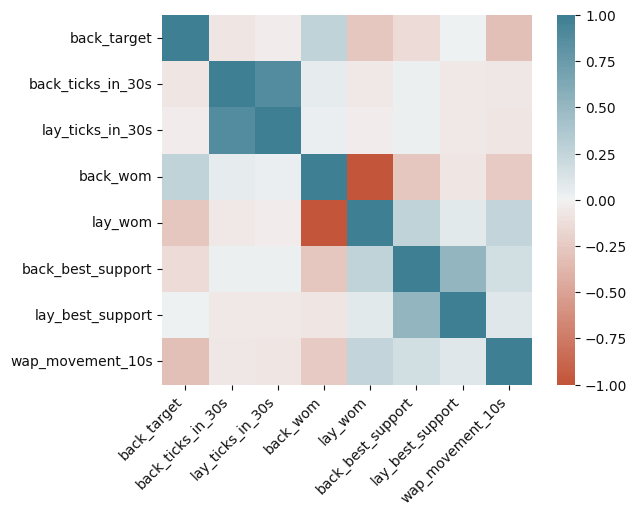

In [42]:
import seaborn as sns

corPlot = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
corPlot.set_xticklabels(
    corPlot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

We're entirely interested in the `back_target` column in the matrix and the heatmap. We can see that some of our candidate features have decent correlation with the number of ticks the price will move over the course of the next 30 seconds.


#### 2.3.4 Next Steps

This marks the end of this analysis however if you're interested in turning this kind of analysis / approach into something more I'd suggest there's two main paths you could go down from here.

1. Angles + Rules

    You could dig into the data a little more a find specific situations where some of these features (or ones like them) preceeded certain things happening in the market (movements or increases in trading volatility etc) You could then construct trading rules based on these findings an try to automate them or bake them into trading rules inside a 3rd party tool.

2. Predictive Modelling

    If you were comfortable with statistical models or machine learning you could easily feed this data into a predictive modelling workflow. Once honed, the predictions from this workflow could be turned into recommended betting decisions which could form a part of an automated algorithmic betting framework. The work to fill out a project like this would be significant but so would the reward.

---

## 3.0 Conclusion

Like previous articles this analysis is a sketch of what can be accomplished analysing the historical stream files. In this instance we focussed on the markets themselves, with a particular focussing on a small slice of markets: victorian thoroughbred markets. We analysed how these markets form, how to interpret the price movements on certain selections and the first steps to building out automated strategies based on these features alone. 

Building automated betting strategies based on the markets alone is path that plenty of quantitatively inclined Betfair customers go down as it minimises complexity in source data (there's only one!) and there's plenty of value in it left untapped for you to try to capture.



---

## Complete code

Run the code from your ide by using `py <filename>.py`, making sure you amend the path to point to your input data. 

[Download from Github](https://github.com/betfair-down-under/autoHubTutorials/tree/master/analysingAndPredictingMarketMovments)

In [ ]:
# %% [markdown]
# # Do #theyknow? Analysing betfair market formation and market movements

# %% [markdown]
# ## 0.1 Setup
# 
# Once again I'll be presenting the analysis in a jupyter notebook and will be using python as a programming language.
# 
# Some of the data processing code takes a while to execute - that code will be in cells that are commented out - and will require a bit of adjustment to point to places on your computer locally where you want to store the intermediate data files.
# 
# You'll also need `betfairlightweight` which you can install with something like `pip install betfairlightweight`.

# %%
import pandas as pd
import numpy as np
import requests
import os
import re
import csv
import plotly.express as px
import plotly.graph_objects as go
import math
import logging
import yaml
import csv
import tarfile
import zipfile
import bz2
import glob
import ast

from datetime import date, timedelta
from unittest.mock import patch
from typing import List, Set, Dict, Tuple, Optional
from itertools import zip_longest
import betfairlightweight
from betfairlightweight import StreamListener
from betfairlightweight.resources.bettingresources import (
    PriceSize,
    MarketBook
)

# %% [markdown]
# ## 0.2 Context
# 
# You may have seen the hashtag if you're on australian racing twitter #theyknow following a dramatic late market move for a horse that's followed by a decisive race victory. Sometimes it can seem eerie how accurate these moves are after the fact. In betfair racing markets there's usually a flurry of activity leading up to the race start as players look to get their bets down at the best price without tipping their hand (opinion on the race) too much. Large moves can happend when large players rally around a selection who's implied chance in early trading isn't close to what it's true chance is in the upcoming race. Large moves can also happen when there's some inside information - not able to be gleaned from analysis of the horses previous races - that slowly filters out of the stable or training group.
# 
# This creates opportunity in the secondary market as punters try to read these movements to make bets themselves. The task often becomes identifying which movements are caused by these sophisticated players or represent real signals of strength and which aren't.
# 
# So do #theyknow generally? Before even looking at the data I can assure you that yes they do know pretty well. Strong movements in betting markets are usually pretty reliable indicators about what is about to happen. However, these moves can be overvalued by recreationals. When observing a horse plumet in from $3.50 to $2 you are usually suprised if the horse loses, but the general efficiency of late prices would suggest that this horse is going to still lose 50% of time. If you simply observe the large moves after the sharp players have corrected the market landscape you're in no better a position to bet than before the move happened. On the other hand what if would could reliably identify the move as it was happening or about to happen? That would be a recipe for successful trading of horse racing markets and no doubt this is what many players in this secondary market (analysis of betfair markets rather than the races themselves) try to do.
# 
# If you were to build up a manual qualitative strategy for this kind of market trading you need to understand:
# - Who the participants are
# - How sophisticated they are at the top end
# - What types of races do they bet on and for how much
# - When the different types of participants typically enter the market 
# - What do bet placement patterns look like for these participants
# - etc.
# 
# This is the kind of task that takes a lot research, years of experience watching markets, a lot of trial and error, and a lot of industry know-how. Given I'm a lazy quantitative person I'll try to see if I can uncover any of these patterns in the data alone.
# 
# Put simply the central question for the second half of this piece will be:
# 
# > How should you think about large price moves in betfair markets and how could you look to build secondary betting strategies by quantitatively analysing historical data
# 
# I'll just be analysing historical thoroughbred markets but the same approach could be applied to any sport or racing code of your interest.

# %% [markdown]
# ## 0.3 This Example
# 
# Building market based trading strategies is a broad and fertile ground for many quantitative betfair customers; too big to cover in a single article. I'll try to zero in on a small slice of thoroughbred markets and analyse how these markets form and how I'd start the process of trying to find the patterns in the market movements. Again hopefully this is some inspiration for you and you can pick up some of the ideas and build them out.
# 
# Given volume of data (when analysing second by second slices of market data) I'll be looking at a years worth of thoroughbred races from the 5 largest Victorian tracks: Flemington, Caulfield, Moonee Valley, Bendigo and Sandown.

# %% [markdown]
# # 1.0 Data
# 
# Unlike in some of the previous tutorials we aren't going to collapse the stream data into a single row per runner. In those examples we were interested in analysing some discrete things about selections in betfair markets like:
# 
# - Their final odds (bsp or last traded price)
# - Their odds at some fixed time point or time points before the scheduled race start
# - Other single number descriptors of the trading activity on a selection (eg total traded volume)
# 
# 
# In this analysis I want to analyse how markets form and prices move for selections as markets evolve. So we'll need to pull out multiple price points per runner - so we'll have multiple rows per runner in our parsed output dataset.
# 
# To output a row for every stream update for every selection in every thoroughbred race over the last 12 months would produce a dataset far too big too analyse using normal data analysis tools - we're about 10s to 100s of billions of rows.
# 
# To chop our sample down into a manageable slice I'm going to filter on some select tracks of interest (as mentioned above) and I'm also going to have 3 sections of data granularity:
# 
# - I won't log any of the odds or traded volumes > 30mins before the scheduled off
#     + In thoroughbreds there is non-trivial action before this point you may want to study, but it's not what I want to study here
# - Between 30 and 10 minutes before the scheduled off I'll log data every 60 seconds
# - 10 minutes or less to the scheuled off I'll log prices every second
# 
# The code to manage this windowed granularity is in the below parsing code tweak as you wish if you want to tighten or broaden the analysis.

# %% [markdown]
# ## 1.1 Sourcing Data
# 
# First you'll need to source the stream file TAR archive files. I'll be analysing 12 months of Australian thoroughbred Pro files. Aask automation@betfair.com.au for more info if you don't know how to do this. Once you've gotten access download them to your computer and store them together in a folder.

# %% [markdown]
# ## 1.2 Utility Functions

# %%
# General Utility Functions
# _________________________________

def as_str(v) -> str:
    return '%.2f' % v if type(v) is float else v if type(v) is str else ''

def split_anz_horse_market_name(market_name: str) -> (str, str, str):
    parts = market_name.split(' ')
    race_no = parts[0] # return example R6
    race_len = parts[1] # return example 1400m
    race_type = parts[2].lower() # return example grp1, trot, pace
    return (race_no, race_len, race_type)


def load_markets(file_paths):
    for file_path in file_paths:
        print(file_path)
        if os.path.isdir(file_path):
            for path in glob.iglob(file_path + '**/**/*.bz2', recursive=True):
                f = bz2.BZ2File(path, 'rb')
                yield f
                f.close()
        elif os.path.isfile(file_path):
            ext = os.path.splitext(file_path)[1]
            # iterate through a tar archive
            if ext == '.tar':
                with tarfile.TarFile(file_path) as archive:
                    for file in archive:
                        yield bz2.open(archive.extractfile(file))
            # or a zip archive
            elif ext == '.zip':
                with zipfile.ZipFile(file_path) as archive:
                    for file in archive.namelist():
                        yield bz2.open(archive.open(file))

    return None

def slicePrice(l, n):
    try:
        x = l[n].price
    except:
        x = ""
    return(x)

def sliceSize(l, n):
    try:
        x = l[n].size
    except:
        x = ""
    return(x)

def pull_ladder(availableLadder, n = 5):
        out = {}
        price = []
        volume = []
        if len(availableLadder) == 0:
            return(out)        
        else:
            for rung in availableLadder[0:n]:
                price.append(rung.price)
                volume.append(rung.size)

            out["p"] = price
            out["v"] = volume
            return(out)

# %% [markdown]
# Slicing the tracks we want we'll just adjust the market filter function used before to include some logic on the venue name

# %%
def filter_market(market: MarketBook) -> bool: 
    
    d = market.market_definition
    track_filter = ['Bendigo', 'Sandown', 'Flemington', 'Caulfield', 'Moonee Valley']

    return (d.country_code == 'AU' 
        and d.venue in track_filter
        and d.market_type == 'WIN' 
        and (c := split_anz_horse_market_name(d.name)[2]) != 'trot' and c != 'pace')

# %% [markdown]
# ## 1.3 Selection Metadata
# 
# Given that the detailed price data will have so many records we will split out the selection metadata (including the selection win outcome flag and the bsp) into it's own dataset much you would do in a relational database to manage data volumes.
# 
# This means we'll have to parse over the data twice but our outputs will be much smaller than if we duplicated the selection name 800 times for example.

# %%
def final_market_book(s):

    with patch("builtins.open", lambda f, _: f):

        gen = s.get_generator()

        for market_books in gen():
            
            # Check if this market book meets our market filter ++++++++++++++++++++++++++++++++++

            if ((evaluate_market := filter_market(market_books[0])) == False):
                    return(None)
            
            for market_book in market_books:

                last_market_book = market_book
        
        return(last_market_book)

def parse_final_selection_meta(dir, out_file):
    
    with open(out_file, "w+") as output:

        output.write("market_id,selection_id,venue,market_time,selection_name,win,bsp\n")

        for file_obj in load_markets(dir):

            stream = trading.streaming.create_historical_generator_stream(
                file_path=file_obj,
                listener=listener,
            )

            last_market_book = final_market_book(stream)

            if last_market_book is None:
                continue 

            # Extract Info ++++++++++++++++++++++++++++++++++

            runnerMeta = [
                {
                    'selection_id': r.selection_id,
                    'selection_name': next((rd.name for rd in last_market_book.market_definition.runners if rd.selection_id == r.selection_id), None),
                    'selection_status': r.status,
                    'win': np.where(r.status == "WINNER", 1, 0),
                    'sp': r.sp.actual_sp
                }
                for r in last_market_book.runners 
            ]

            # Return Info ++++++++++++++++++++++++++++++++++

            for runnerMeta in runnerMeta:

                if runnerMeta['selection_status'] != 'REMOVED':

                    output.write(
                        "{},{},{},{},{},{},{}\n".format(
                            str(last_market_book.market_id),
                            runnerMeta['selection_id'],
                            last_market_book.market_definition.venue,
                            last_market_book.market_definition.market_time,
                            runnerMeta['selection_name'],
                            runnerMeta['win'],
                            runnerMeta['sp']
                        )
                    )

# %%
selection_meta = "[OUTPUT PATH TO CSV FOR SELECTION METADATA]"
stream_files = glob.glob("[PATH TO STREAM FILES]*.tar")
trading = betfairlightweight.APIClient(username = "username", password = "password", app_key="app_key")
listener = StreamListener(max_latency=None)

print("__ Parsing Selection Metadata ___ ")
# parse_final_selection_meta(stream_files, selection_meta)

# %% [markdown]
# ## 1.4 Detailed Preplay Odds
# 
# Like mentioned above there will be some time control logic injected to control the time granularity that odds are recorded in each step.
# 
# Instead of widening the available to bet price ladder I'll extract the top 10 rungs of the available to back (atb) and available to lay (atl) ladders and write them both to the output file. That will give me more flexibility during the analysis to pull out things that interest me. So in total I'll extract:
# 
# - Top 10 ATB Ladder
# - Top 10 ATL Ladder
# - Total Traded Volume
# - Volume weighted average traded price up till the current time
# - Last Traded price
# 

# %%
def loop_preplay_prices(s, o):

    with patch("builtins.open", lambda f, _: f):

        gen = s.get_generator()

        marketID = None
        tradeVols = None
        time = None

        for market_books in gen():

            # Check if this market book meets our market filter ++++++++++++++++++++++++++++++++++

            if ((evaluate_market := filter_market(market_books[0])) == False):
                    break

            for market_book in market_books:

                # Time Step Management ++++++++++++++++++++++++++++++++++

                if marketID is None:

                    # No market initialised
                    marketID = market_book.market_id
                    time =  market_book.publish_time

                elif market_book.inplay:

                    # Stop once market goes inplay
                    break

                else:
                    
                    seconds_to_start = (market_book.market_definition.market_time - market_book.publish_time).total_seconds()

                    if seconds_to_start > log1_Start:
                        
                        # Too early before off to start logging prices
                        continue

                    else:
                    
                        # Update data at different time steps depending on seconds to off
                        wait = np.where(seconds_to_start <= log2_Start, log2_Step, log1_Step)

                        # New Market
                        if market_book.market_id != marketID:
                            marketID = market_book.market_id
                            time =  market_book.publish_time
                        # (wait) seconds elapsed since last write
                        elif (market_book.publish_time - time).total_seconds() > wait:
                            time = market_book.publish_time
                        # fewer than (wait) seconds elapsed continue to next loop
                        else:
                            continue

                # Execute Data Logging ++++++++++++++++++++++++++++++++++
                                                
                for runner in market_book.runners:

                    try:
                        atb_ladder = pull_ladder(runner.ex.available_to_back, n = 10)
                        atl_ladder = pull_ladder(runner.ex.available_to_lay, n = 10)
                    except:
                        atb_ladder = {}
                        atl_ladder = {}

                    # Calculate Current Traded Volume + Tradedd WAP
                    limitTradedVol = sum([rung.size for rung in runner.ex.traded_volume])
                    if limitTradedVol == 0:
                        limitWAP = ""
                    else:
                        limitWAP = sum([rung.size * rung.price for rung in runner.ex.traded_volume]) / limitTradedVol
                        limitWAP = round(limitWAP, 2)

                    o.writerow(
                        (
                            market_book.market_id,
                            runner.selection_id,
                            market_book.publish_time,
                            limitTradedVol,
                            limitWAP,
                            runner.last_price_traded or "",
                            str(atb_ladder).replace(' ',''), 
                            str(atl_ladder).replace(' ','')
                        )
                    )




def parse_preplay_prices(dir, out_file):
    
    with open(out_file, "w+") as output:

        writer = csv.writer(
            output, 
            delimiter=',',
            lineterminator='\r\n',
            quoting=csv.QUOTE_ALL
        )
        
        writer.writerow(("market_id","selection_id","time","traded_volume","wap","ltp","atb_ladder","atl_ladder"))

        for file_obj in load_markets(dir):

            stream = trading.streaming.create_historical_generator_stream(
                file_path=file_obj,
                listener=listener,
            )

            loop_preplay_prices(stream, writer)

# %%
preplay_price_file =  "[OUTPUT PATH TO CSV FOR PREPLAY PRICES]"
stream_files = glob.glob("[PATH TO STREAM FILES]*.tar")


log1_Start = 60 * 30 # Seconds before scheduled off to start recording data for data segment one
log1_Step = 60       # Seconds between log steps for first data segment
log2_Start = 60 * 10  # Seconds before scheduled off to start recording data for data segment two
log2_Step = 1        # Seconds between log steps for second data segment

print("__ Parsing Detailed Preplay Prices ___ ")
# parse_preplay_prices(stream_files, preplay_price_file)

# %% [markdown]
# # 2.0 Analysis

# %% [markdown]
# ## 2.1 Load and Assemble
# 
# First let's load the raw datafiles we created in the previous step. 
# 
# ## 2.1.1 Load

# %% [markdown]
# We have the highlevel selection metadata (1 row per selection):
# 

# %%
selection_meta_path = "[PATH TO METADATA FILE]"
selection = pd.read_csv(selection_meta_path , dtype={'market_id': object, 'selection_id': object}, parse_dates = ['market_time'])
selection.head(3)

# %% [markdown]
# And we have the detailed preplay price data for these markets + selections:

# %%
prices_path = "[PATH TO PRICES FILE]"

prices = pd.read_csv(
    prices_path, 
    quoting=csv.QUOTE_ALL,
    dtype={'market_id': 'string', 'selection_id': 'string', 'atb_ladder': 'string', 'atl_ladder': 'string'},
    parse_dates=['time']
)
prices.head(3)

# %% [markdown]
# Now it's important to observe how much data we have here.

# %%
prices.shape

# %% [markdown]
# We've got 7 million rows of price data here just for races at 5 thoroughbred tracks over the last year. Now it's not really "big data" in the sense you might have heard before but it's certainly a lot of rows and we'll have to think about the performance of our code a little bit more than we would if we were dealining with 1 row per selection style datasets.

# %% [markdown]
# We need pandas to correctly interpret the dictionary columns as dictionaries so we'll run this code:

# %%
# To get pandas to correctly recognise the ladder columns as dictionaries
prices['atb_ladder'] = [ast.literal_eval(x) for x in prices['atb_ladder']]
prices['atl_ladder'] = [ast.literal_eval(x) for x in prices['atl_ladder']]

# %% [markdown]
# ## 2.1.2 Assemble

# %% [markdown]
# Now we'll join the 2 data sets together to form a nice normalised dataframe:

# %%
# Simple join on market and selection_id initially
df = selection.merge(prices, on = ['market_id', 'selection_id'])
df.head(3)

# %% [markdown]
# ## 2.1.3 Transform
# 
# Next we'll do some processing on the joined dataframe to add some columns that we can use in our analysis including calculating a numeric #seconds before the scheduled jump field that we'll use extensively.

# %%
df = (
    df
    .assign(back_best = lambda x: [np.nan if d.get('p') is None else d.get('p')[0] for d in x['atb_ladder']])
    .assign(lay_best = lambda x: [np.nan if d.get('p') is None else d.get('p')[0] for d in x['atl_ladder']])
    .assign(back_vwap = lambda x: [np.nan if d.get('p') is None else round(sum([a*b for a,b in zip(d.get('p')[0:3],d.get('v')[0:3])]) / sum(d.get('v')[0:3]),3) for d in x['atb_ladder']])
    .assign(lay_vwap = lambda x: [np.nan if d.get('p') is None else round(sum([a*b for a,b in zip(d.get('p')[0:3],d.get('v')[0:3])]) / sum(d.get('v')[0:3]),3) for d in x['atl_ladder']])
    .assign(seconds_before_scheduled_jump = lambda x: round((x['market_time'] - x['time']).dt.total_seconds()))
    .query('seconds_before_scheduled_jump < 1800 and seconds_before_scheduled_jump > -120')
)

# %% [markdown]
# ## 2.2 Market Formation
# 
# Before we analyse how prices for selections move let's understand some basic things about how thoroughbred markets form.

# %% [markdown]
# ## 2.2.1 Traded Volumes
# 
# Let's look at how a typical market (at one of these 5 tracks) trades leading up to the scheduled race start.
# 
# To make some of the analysis a little bit cleaner we need to pad out missing odds updates. For example for a given market we might have a market update 140 seconds before the jump but not another one till 132 seconds before the jump. We'll add rows for those interim 8 seconds by filling the values from the the previous row, this is required to iron out some idiosyncracies in the aggregations, it's not that important to follow if you don't understand it.

# %%
traded_volume_values = df[['market_id', 'selection_id', 'venue', 'bsp', 'seconds_before_scheduled_jump', 'traded_volume']]
all_sbj = pd.DataFrame(data = {'seconds_before_scheduled_jump': traded_volume_values.seconds_before_scheduled_jump.unique()}).assign(join = 1)
traded_volume_explode = traded_volume_values[['market_id', 'selection_id', 'venue', 'bsp']].drop_duplicates().assign(join = 1).merge(all_sbj).drop('join', 1)
traded_volume_df = traded_volume_explode.merge(traded_volume_values, how = "left")
traded_volume_df = traded_volume_df.sort_values(['market_id', 'selection_id', 'venue', 'seconds_before_scheduled_jump'], ascending=[True, True, True, False])
traded_volume_df.update(traded_volume_df.groupby(['market_id', 'selection_id', 'venue'])[['seconds_before_scheduled_jump', 'traded_volume']].ffill().fillna(0))

# %%
# Group by market, sum volume over selections at a given time, average over times for total
def chunkSBJ(sbj):
    if sbj < 600:
        return(sbj)
    else:
        return(int(math.floor(sbj / 60) * 60))

tradedVolumes_1 = (
    traded_volume_df
    .groupby(["market_id", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'traded_volume': 'sum'})
    .assign(seconds_before_scheduled_jump = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .groupby("seconds_before_scheduled_jump", as_index = False)
    .agg({'traded_volume': 'mean'})
    .sort_values('seconds_before_scheduled_jump', ascending=False)
)

fig = px.area(
    tradedVolumes_1, 
    x='seconds_before_scheduled_jump', y='traded_volume', 
    template='plotly_white',
    title="Traded Volume Leading Up To Race Jump (Major Victorian Tracks)",
    labels = {
        'seconds_before_scheduled_jump': "Seconds Before Scheduled Jump",
        "traded_volume": "Average Cumulative Traded Volume"
    }
    #subtitle = "Top 5 Biggest Vic Track Sample"
)
fig.update_layout(font_family="Roboto")
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show("png")

# %% [markdown]
# The discontinuity in the chart highlights the switch point between the two time granularities that we extracted from the stream. Pre 600 seconds (10 minutes) before the scheduled off I can plot 1 data point per minute and after I'm plotting 60 data points per minute.
# 
# The traded volume chart looks like an exponential chart: the total traded volume doubles from 10 minutes out to 4 minutes out, then it doubles again between then and 1 minute out, then nearly doubling again in the last minute and a bit of trading. Even a simple visual like this can help you with your bet placement on betfair markets. For example if you're planning to get large volumes down on betfair thoroughbred markets it's probably best to view prices >10 minutes out with a skeptical eye even if the market is tight - because you won't find the requisite lay volume that early as the majority of traded volume happens in the last 2-5 minutes of trading.
# 
# Now like most analysis the average is definitely hiding lots of interesting things about this data. Let's split out this data by our 5 tracks:

# %%
tradedVolumes_2 = (
   traded_volume_df
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .groupby(["market_id", "venue", "seconds_before_scheduled_jump_chunk", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'traded_volume': 'sum'})
    .groupby(["venue", "seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'traded_volume': 'mean'})
    .sort_values('seconds_before_scheduled_jump_chunk', ascending=False)
)

fig_2 = px.line(
    tradedVolumes_2, 
    x='seconds_before_scheduled_jump_chunk', y='traded_volume',  color='venue',
    template='plotly_white',
    title="Traded Volume Leading Up To Race Jump (Major Victorian Tracks)",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "traded_volume": "Average Cumulative Traded Volume"
    }
)
fig_2.update_layout(font_family="Roboto")
fig_2['layout']['xaxis']['autorange'] = "reversed"
fig_2.show("png")

# %% [markdown]
# As expected an average Flemington race trades nearly 500k whereas an average Bendigo race trades only ~120k volume.
# 
# How about if we split our selections by odds range. Intuitively we know that odds-on horses will trade significantly more volume than a $50 shot but let's visualise the difference.
# 
# We'll chunk the BSP of each horse into 5 groups:
# - Odds on (<50% chance of winning)
# - Odds between 2 and 5
# - Odds between 5 and 15
# - Odds between 15 and 50
# - Odds 50+

# %%
def chunkBsp(bsp):
    if bsp <= 2:
        return("1. Odds On")
    elif bsp <= 5:
        return("2. (2, 5]")
    elif bsp <= 15:
        return("3. (5, 15]")
    elif bsp <= 50:
        return("4. (15, 50]")
    else:
        return("5. 50+")

# Group by odds range
tradedVolumes_3 = (
    traded_volume_df
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(bsp = lambda x: x['bsp'].apply(chunkBsp))
    .groupby(["market_id", "bsp", "seconds_before_scheduled_jump_chunk", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'traded_volume': 'sum'})
    .groupby(["bsp", "seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'traded_volume': 'mean'})
)

fig_3 = px.line(
    tradedVolumes_3, 
    x='seconds_before_scheduled_jump_chunk', y='traded_volume', color='bsp',
    template='plotly_white',
    title="Traded Volume Leading Up To Race Jump (Major Victorian Tracks)",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "traded_volume": "Average Cumulative Traded Volume"
    }
)
fig_3.update_layout(font_family="Roboto")
fig_3['layout']['xaxis']['autorange'] = "reversed"
fig_3.show("png")

# %% [markdown]
# Again as expected the traded volume is strongly inversely proportional to the implied chance. There's a few reasons for this: 
# - Inherently exposure is inversely proportional to odds so the same stake can produce widely different exposures for lay betting
# - Non model based participants have limited resources to manually analyse the form and thus focus on the top end of the market
# - Higher chance events reduce variance which is captured in staking schemes like the kelly criterion (which overweight stakes on larged percieved advantages on high probability events) that sophisticated participants tend to use
# 
# Knowing where a majority of the traded volume is concentrated is another thing you should be aware of whether your betting on horse racing or elections and everything in between.

# %% [markdown]
# ## 2.2.2 Market Tightness
# 
# Understanding how the market tightens before the off is also another key conceptual component to market formation. I will consider two different variations on this concept:
# 
# - Market overround or Market Percentage
#     + The sum of probabilities across all outcomes
#     + Back % are always above 1 (else there exists an arbitrage opportunity)
#     + Lay % are always below 1 (else there exists an arbitrage opportunity)
# - Market Spread
#     + The # of ticks / rungs between the best available back price and the best available lay price
# 
# The market % is the value displayed on the betfair website here

# %% [markdown]
# ![](img/overround.png)

# %%
averageMarketPct = (
    df[['market_id', 'selection_id', 'seconds_before_scheduled_jump', 'back_best', 'lay_best']]
    .query('seconds_before_scheduled_jump >= -20')
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(
        back_best = lambda x: 1 / x['back_best'],
        lay_best = lambda x: 1 / x['lay_best']
    )
    .groupby(["market_id", "seconds_before_scheduled_jump_chunk", "seconds_before_scheduled_jump"], as_index = False)
    .agg({'back_best': 'sum', 'lay_best': 'sum'})
    .groupby("seconds_before_scheduled_jump_chunk", as_index = False)
    .agg({'back_best': 'mean', 'lay_best': 'mean'})
    .sort_values('seconds_before_scheduled_jump_chunk', ascending=False)
)

fig_4 = go.Figure()
fig_4.add_trace(go.Scatter(x=averageMarketPct['seconds_before_scheduled_jump_chunk'], y=averageMarketPct['back_best'],
                    mode='lines',
                    name='Back Market Overround'))
fig_4.add_trace(go.Scatter(x=averageMarketPct['seconds_before_scheduled_jump_chunk'], y=averageMarketPct['lay_best'],
                    mode='lines',
                    name='Lay Market Overround'))
fig_4.update_layout(
    font_family="Roboto", 
    template="plotly_white",
    title='Average Back + Lay Market Overound Vic Thoroughbreds'
)
fig_4.update_xaxes(title = "Seconds Before Scheduled Jump")
fig_4['layout']['xaxis']['autorange'] = "reversed"
fig_4.show("png")

# %% [markdown]
# As you can see the back and lay market % converge to 1 as the market gets closer to the jump. However, these are generally great markets even 30 mins before the off to have overrounds of only 4% is very good for racing markets. 
# 
# If you were analysing different kinds of racing markets, however, (harness or greyhound markets or thoroughbred races for country meets) you may need to conduct this kind of analysis to see when the earliest time you're likely to be able to get fair prices on either side of the market.
# 
# Another way we can measure the tightness of betfair markets is the market spread. I'm going to define the market spread as the number of ticks between the best back and best lay prices. This can give some extra granularity when measuring the market tightness for an individual selection

# %% [markdown]
# ![](img/market-spread.png)

# %% [markdown]
# In this market for example we can see that the first selection has a spread of 5 ticks between 11 and 13.5 (where ticks are 0.5 apart) whereas there's only 2 ticks between the best back and lay for the market favourite 3.4 and 3.5 (where ticks are 0.05 apart).
# 
# First we'll need to create some custom functions that will create the betfair ladder and do betfair "tick arithmetic" for us. Part of the reason that I'm creating a different view for market spread is as a reason to introduce this betfair tick ladder concept. Measuring odds differences and movement between odds values can be tricky because prices are fairly non-linear in probability space (you see far more horses between 2 and 3 than you do between 802 and 803 for example). Converting prices to a rank on the betfair tick ladder creates a nice output mapping that can be used for all kinds of other purposes.

# %%
# Define the betfair tick ladder
def bfTickLadder():

    tickIncrements = {
        1.0: 0.01,
        2.0: 0.02,
        3.0: 0.05,
        4.0: 0.1,
        6.0: 0.2,
        10.0: 0.5,
        20.0: 1.0,
        30.0: 2.0,
        50.0: 5.0,
        100.0: 10.0,
        1000.0: 1000,
    }

    ladder = []

    for index, key in enumerate(tickIncrements):

        increment = tickIncrements[key]

        if (index+1) == len(tickIncrements):
            ladder.append(key)
        else:
            key1 = [*tickIncrements][index]
            key2 = [*tickIncrements][index+1]
            steps = (key2 - key1) / increment

            for i in range(int(steps)):
                ladder.append(round(key + i * increment, 2))

    return(ladder)

bfticks = bfTickLadder()
    
# Round a decimal to the betfair tick value below
def bfTickFloor(price, includeIndex=False):

    if 'bfticks' in globals():
        global bfticks
    else:
        bfticks = bfTickLadder()

    ind = [ n for n,i in enumerate(bfticks) if i>=price][0]
    if includeIndex:
        if bfticks[ind]==price:
            return((ind, price))
        else:
            return((ind-1, bfticks[ind-1]))
    else:
        if bfticks[ind]==price:
            return(price)
        else:
            return(bfticks[ind-1])

# Calculate the numder of ticks between two tick values
def bfTickDelta(p1, p2):

    if np.isnan(p1) or np.isnan(p2):
        return(np.nan)

    x = bfTickFloor(p1, includeIndex=True)
    y = bfTickFloor(p2, includeIndex=True)
    return(x[0]-y[0])

# %%
bfTickDelta(13.5, 11)

# %%
bfTickDelta(3.5, 3.4)

# %% [markdown]
# Now that we have our functions let's plot the average market spread leading up to the jump.

# %%
# Group by odds range
averageMarketSpread = (
    df[['market_id', 'selection_id', 'seconds_before_scheduled_jump', 'back_best', 'lay_best']]
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(market_spread = lambda x: x.apply(lambda x: bfTickDelta(x.lay_best, x.back_best), axis=1))
    .groupby(["seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'market_spread': 'mean'})
)

# %%

fig_5 = px.line(
    averageMarketSpread, 
    x='seconds_before_scheduled_jump_chunk', y='market_spread',
    template='plotly_white',
    title="Market Spread Leading Up To Jump",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "market_spread": "Average Spread (b/w best back and lay)"
    }
)
fig_5.update_layout(font_family="Roboto")
fig_5['layout']['xaxis']['autorange'] = "reversed"
fig_5.show("png")

# %% [markdown]
# So much the same story as before, the spread tightens pretty dramatically leading all the way up to the jump. Now that we have a measure for market tightness on a selection level we can split it by odds range to see how tightness varies across odds range.

# %%
# Market Spread By Odds Group
# _______________________

# Group by odds range
averageMarketSpreadOddsgrp = (
    df[['market_id', 'selection_id', 'bsp','seconds_before_scheduled_jump', 'back_best', 'lay_best']]
    .assign(seconds_before_scheduled_jump_chunk = lambda x: x['seconds_before_scheduled_jump'].apply(chunkSBJ))
    .assign(bsp = lambda x: x['bsp'].apply(chunkBsp))
    .assign(market_spread = lambda x: x.apply(lambda x: bfTickDelta(x.lay_best, x.back_best), axis=1))
    .groupby(["bsp", "seconds_before_scheduled_jump_chunk"], as_index = False)
    .agg({'market_spread': 'mean'})
)

fig_6 = px.line(
    averageMarketSpreadOddsgrp, 
    x='seconds_before_scheduled_jump_chunk', y='market_spread', color = "bsp",
    template='plotly_white',
    title="Market Spread Leading Up To Jump",
    labels = {
        'seconds_before_scheduled_jump_chunk': "Seconds Before Scheduled Jump",
        "market_spread": "Average Spread (b/w best back and lay)"
    }
)
fig_6.update_layout(font_family="Roboto")
fig_6['layout']['xaxis']['autorange'] = "reversed"
fig_6.show("png")

# %% [markdown]
# Now this gives us visibility of how the market tightens across groups of selections. Clearly the bottom end of the market takes a bit longer to tighten up which fits our understanding that there's generally less money, and less very sharp money on these selections.

# %% [markdown]
# ## 2.3 Market Moves
# 
# Circling back to the motivation of this article: 
# 
# > How should you think about large price moves in betfair markets and how could you look to build secondary betting strategies by quantitatively analysing historical data
# 
# Now that we have a good grasp on the data we've collected on how betfair markets form let's try to analyse big price moves. Here's a sample of our largest price moves in our race sample:
# 
# 

# %%
# Big Movers
# ____________________

(
    df
    .groupby(['market_id', 'selection_id', 'venue', 'selection_name', 'win', 'bsp'], as_index = False)
    .agg({'ltp': 'max'})
    .rename(columns = {'ltp': 'max_traded'})
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.max_traded, x.bsp), axis=1))
    .query('max_traded < 500')
    .sort_values('ticks_in', ascending = False)
    .head(10)
)

# %% [markdown]
# Some of those moves are astounding: San Fabrizio traded at 10.50 in the last 30 mins before the jump and had a final BSP of 2.80, but lost. 
# 
# Like we discussed before observing a market plunge in hindsight may seem like a more powerful predictor than it actually is. For example, if we had have flat staked these 10 giant moves after they happened (say at the BSP) we'd be running at ~70% POT even though our intuition would have told you at the time that these horses couldn't lose!

# %% [markdown]
# ## 2.3.1 Reacting to moves after they happen
# 
# Bookies, race callers and other services will often tell you what selection has been strong in the market; who the "money" has come for. But once you hear this is it already too late to do anything about?
# 
# Let's extend the sample in the previous section to see if we can draw any broader conclusions.
# 
# - I'll take a sample of the all selections 10 minutes before the scheduled jump
# - I'll also take those same selections at the scheduled jump exactly
# - I'll then calculate the number of ticks between the best back price at each time point to measure the movement in the last 10 minutes of trading
# - I'll then calculate a back and lay profit using the top box at the scheduled off

# %%
m10 = (
    df
    .groupby(['market_id', 'selection_id'], as_index = False)
    .apply(lambda g: None if g[g['seconds_before_scheduled_jump'] < 600].shape[0] == 0 else g[g['seconds_before_scheduled_jump'] < 600].sort_values('seconds_before_scheduled_jump', ascending = False).iloc[0])
    .filter(items = ['market_id', 'selection_id', 'venue', 'selection_name', 'win', 'back_best', 'lay_best'])
    .rename(columns = {'back_best': 'back_best_10m', 'lay_best': 'lay_best_10m'})
)

m0 = (
    df
    .groupby(['market_id', 'selection_id'], as_index = False)
    .apply(lambda g: None if g[g['seconds_before_scheduled_jump'] < 0].shape[0] == 0 else g[g['seconds_before_scheduled_jump'] < 0].sort_values('seconds_before_scheduled_jump', ascending = False).iloc[0])
    .filter(items = ['market_id', 'selection_id', 'venue', 'selection_name', 'win', 'back_best', 'lay_best'])
)

# %%
# Back or lay according to large plunges
pd.DataFrame( 
    m10.merge(m0)
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_10m, x.back_best), axis=1))
    .query('ticks_in >= 15')
    .assign(back_pl = lambda x:  np.where(x['win'] == 1, 0.95 * (x['back_best']-1), -1))
    .assign(lay_pl = lambda x:  np.where(x['win'] == 1, -1*(x['lay_best']-1), 0.95))
    .assign(stake = 1)
    .agg({'stake': 'sum', 'back_pl': 'sum', 'lay_pl': 'sum'})
)

# %%
# Back or lay according to large plunges - grouped by track
( 
    m10.merge(m0)
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_10m, x.back_best), axis=1))
    .query('ticks_in >= 15')
    .assign(back_pl = lambda x:  np.where(x['win'] == 1, 0.95 * (x['back_best']-1), -1))
    .assign(lay_pl = lambda x:  np.where(x['win'] == 1, -1*(x['lay_best']-1), 0.95))
    .assign(stake = 1)
    .groupby('venue', as_index = False)
    .agg({'stake': 'sum', 'back_pl': 'sum', 'lay_pl': 'sum'})
)

# %% [markdown]
# As you can see there's not much of a pattern here to take advantage of here. At least for this sample of tracks, and for this time slice, the value has been sucked dry from the market on these selections. 
# To illustrate this let's check what the backers would have profited if they were the ones who could identify these selections prior to their big market moves

# %%
# Backing before the plunge?
( 
    m10.merge(m0)
    .assign(ticks_in = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_10m, x.back_best), axis=1))
    .query('ticks_in >= 15')
    .assign(back_pl = lambda x:  np.where(x['win'] == 1, 0.95 * (x['back_best_10m']-1), -1))
    .assign(lay_pl = lambda x:  np.where(x['win'] == 1, -1*(x['lay_best_10m']-1), 0.95))
    .assign(stake = 1)
    .agg({'stake': 'sum', 'back_pl': 'sum', 'lay_pl': 'sum'})
)

# %% [markdown]
# I could sign up for winning at 50% POT! Now I just have to pick 100% of the large thoroughbred plunges before they happen... Obviously no one individual person or group is predicting these movements 100%. Even the sharpest players will have movements go against them but this highlights the essence of the problem and the contradiction of retrospective price movement analysis.
# 
# These movements are important. There is a lot to be gained by purely trading betfair markets and how they move. However, identifting large moves **after** they occur isn't good enough. The large players sharpen the odds down to a good and fair implied chance and leave those watching on the sidelines with little to no value either side. To profit then we must capture some of the value as they are and jump on momentum as it's happening not after it's come to a halt.

# %% [markdown]
# ## 2.3.2 Visualising the moves
# 
# In the final section I'll frame how I think you could go about identifying these moves as they're happening or about to happen. But first to illustrate some of dynamics let's visualise some of these large moves. How do selections firm and do they do it with different characteristics in different patterns? Candlestick charts are a good way to visualise the evolution of prices in markets and are often used in financial markets to do technical analysis.
# 
# I'll first create a function to create a candlestick chart for a market / selection slice of our dataframe using plotly charts.
# 

# %%
# Candlestick Plotly Chart With Plotly
# _____________________________

def priceCandlestickPlotly(d):

    d['time_chunk'] = d['time'].dt.round('2min')  

    selectionName = d.selection_name.iloc[0]
    track = d.venue.iloc[0]
    startTime = d.market_time.iloc[0]

    candleStickInput = d.groupby('time_chunk', as_index=False).agg({"ltp": ['first', 'last', 'min', 'max']})

    candleStickInput.columns = ["_".join(pair) for pair in candleStickInput.columns]

    fig = go.Figure(data=[go.Candlestick(x=candleStickInput['time_chunk_'],
                    open=candleStickInput['ltp_first'],
                    high=candleStickInput['ltp_max'],
                    low=candleStickInput['ltp_min'],
                    close=candleStickInput['ltp_last'])])
    fig.update_layout(
        template="plotly_white", 
        xaxis_rangeslider_visible=False,
        title=f'{selectionName} at {track} race started at {startTime} UTC'
    )
    fig.show("png")

# %% [markdown]
# Let's visualise the 2 biggest moves with this chart function.

# %%
priceCandlestickPlotly(df.query('market_id == "1.182760338" and selection_id == "39317622"'))

# %% [markdown]
# This looks exactly like what we'd expect from a extreme plunge: consistent, sustained and unrelenting support on the back side as the horse is pushed from 8-10 odds down to it's fair odds of around 3.
# 
# Let's look at the second big plunge:

# %%
priceCandlestickPlotly(df.query('market_id == "1.173069469" and selection_id == "35981261"'))

# %% [markdown]
# This movement chart is a bit different. The market has 4 distinct segments:
# 
# - About 30 minutes from the off the market changes and the horse is supported from 4 into 3
# - It trades at around 3 for the next 25 minutes
# - It then drifts back out sharply to a bit over 4
# - It then gets crunched back in all the way into a BSP of 2.30
# 
# Clearly different segments of the participants had very different perceptions of this horses chances. How do we make sense of it?
# 
# Let's try a different candlestick visualistion, which includes the traded volume.

# %%
import mplfinance as fplt

def priceCandlestickMpl(d):

    d['time_chunk'] = d['time'].dt.round('2min')  

    selectionName = d.selection_name.iloc[0]
    track = d.venue.iloc[0]
    startTime = d.market_time.iloc[0]

    # Add traded volume in last interval
    d = d.groupby(['market_id', 'selection_id']).apply(lambda x: x.assign(traded_volume_delta = lambda y: (y['traded_volume'] - y['traded_volume'].shift(1)).mask(pd.isnull, 0)))

    candleStickInput = d.groupby('time_chunk', as_index=False).agg({"ltp": ['first', 'last', 'min', 'max'], "traded_volume_delta": 'sum'})

    candleStickInput.columns = ["_".join(pair) for pair in candleStickInput.columns]

    candleStickInput = candleStickInput.rename(columns = {'time_chunk_': 'date','ltp_first': 'open', 'ltp_last': 'close', 'ltp_min': 'low', 'ltp_max': 'high', 'traded_volume_delta_sum': 'volume'})

    candleStickInput = candleStickInput.set_index('date')

    fplt.plot(
        candleStickInput,
        type='candle',
        style='yahoo',
        title= f'{selectionName} at {track} race started at {startTime} UTC',
        ylabel='Odds',
        volume=True,
        ylabel_lower='Volume Traded',
    )

# %% [markdown]
# First the first horse:

# %%
priceCandlestickMpl(df.query('market_id == "1.182760338" and selection_id == "39317622"'))

# %% [markdown]
# Now the second selection:

# %%
priceCandlestickMpl(df.query('market_id == "1.173069469" and selection_id == "35981261"'))

# %% [markdown]
# So as the majority of the volume was traded right before the jump, the price was hammered into 2.30. This is a pattern that you might see a lot in betfair markets: prices may oscillate around or even drift consistently in one direction until a point at which certain large participants or groups of participants enter the market and push the selection in another direction completely.
# 
# So anticipating a move won't be as simple as analysing the price as a time series, it's one piece of the puzzle. Really sophisticated market trading algorithms will need to historically analyse a raft of market metrics and correlate them with these movements historically within the market type of interest. In the next section I'll start off down that road to give you an idea of how I'd tackle the problem but it's more complicated than we can uncover in a single article.

# %% [markdown]
# ## 2.3.3 Anticipating a move
# 
# Our retrospective analysis was good to help us understand the dynamics of movements, the efficiency of markets, how they form, and what things we could put in a predictive analysis. The next step is to create forward looking estimates about where the market is headed next.
# 
# You get setup your problem in lots of different ways including creating rules based strategies like discussed in a [previous piece](https://betfair-datascientists.github.io/tutorials/automatedBettingAnglesTutorial/). Or you could go down a formalised machine learning approach. The first step to both is to build up some key features and test their predictive power.
# 
# The factors I'll consider in this section will be:
# 
# - The movement over the last 30 seconds
# - The weight of money on the back side
# - The weight of money on the lay side
# - The current best back / volume weighted average top 3 back (top box support on back side)
# - The current best lay / volume weighted average top 3 lay (top box support on lay side)
# - The current best back / The volume weighted traded price over the last increment
# - The current best lay  / The volume weighted traded price over the last increment
# 
# And im interested in correlating these variables with the number + direction of ticks moved over the **next 30 seconds** to see if I can find anything interesting.
# 

# %%
# Start Analysis
# ______________________________

dfPredict = df.query('seconds_before_scheduled_jump <= 600 and seconds_before_scheduled_jump >= 0')

# Target
# ____________________________

dfPredict['best_back_30s_in_future'] =  dfPredict.groupby(['market_id', 'selection_id'])['back_best'].shift(-30)
dfPredict['best_lay_30s_in_future'] = dfPredict.groupby(['market_id', 'selection_id'])['back_best'].shift(-30)

dfPredict['back_target'] = dfPredict.apply(lambda x: bfTickDelta(x.back_best, x.best_back_30s_in_future), axis=1)
dfPredict['lay_target'] =  dfPredict.apply(lambda x: bfTickDelta(x.lay_best, x.best_lay_30s_in_future), axis=1)

# Movement 
# ____________________________

dfPredict['back_best_30s_ago'] = dfPredict.groupby(['market_id', 'selection_id'])['back_best'].shift(30)
dfPredict['back_lay_30s_ago'] = dfPredict.groupby(['market_id', 'selection_id'])['lay_best'].shift(30)

dfPredict = (
    dfPredict
    .assign(back_ticks_in_30s = lambda x: x.apply(lambda x: bfTickDelta(x.back_best_30s_ago, x.back_best), axis=1))
    .assign(lay_ticks_in_30s = lambda x: x.apply(lambda x: bfTickDelta(x.back_lay_30s_ago, x.lay_best), axis=1))
)

# Weight Of Money
# ____________________________

atb_ladder = dfPredict.atb_ladder.iloc[0]
atl_ladder = dfPredict.atl_ladder.iloc[0]

def wom(back_ladder, lay_ladder):

    if not back_ladder or not lay_ladder:
        return((None, None))

    total_volume = round(sum(back_ladder['v']) + sum(lay_ladder['v']),2)

    return((round(sum(back_ladder['v']) / total_volume,3), round(sum(lay_ladder['v']) / total_volume,3)))


dfPredict['wom'] = dfPredict.apply(lambda x: wom(x['atb_ladder'], x['atl_ladder']), axis = 1)

dfPredict[['back_wom', 'lay_wom']] = pd.DataFrame(dfPredict['wom'].tolist(), index=dfPredict.index)

# Top Box Support
# ________________________

dfPredict['back_best_support'] = dfPredict['back_vwap'] / dfPredict['back_best']
dfPredict['lay_best_support'] = dfPredict['lay_best'] / dfPredict['lay_vwap']

# Recent Movement
# _____________________

dfPredict['wap_movement_10s'] = dfPredict['wap'] / dfPredict.groupby(['market_id', 'selection_id'])['wap'].shift(-10)

# %% [markdown]
# Now that we've created the candidate factors let's use a spearman correlation coefficient to analyse their correlation (positive or negative we're mostly focussed on the absolute size of the coefficient).

# %%
corrMatrix = dfPredict[['back_target', 'back_ticks_in_30s', 'lay_ticks_in_30s', 'back_wom', 'lay_wom', 'back_best_support', 'lay_best_support', 'wap_movement_10s']].dropna().corr(method = "spearman")
corrMatrix[['back_target']]

# %%
import seaborn as sns

corPlot = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
corPlot.set_xticklabels(
    corPlot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# %% [markdown]
# We're entirely interested in the `back_target` column in the matrix and the heatmap. We can see that some of our candidate features have decent correlation with the number of ticks the price will move over the course of the next 30 seconds.
# 
# 
# ## 2.3.4 Next Steps
# 
# This marks the end of this analysis however if you're interested in turning this kind of analysis / approach into something more I'd suggest there's 2 main paths you could go down from here.
# 
# 1. Angles + Rules
# 
# You could dig into the data a little more a find specific situations where some of these features (or ones like them) preceeded certain things happening in the market (movements or increases in trading volatility etc) You could then construct trading rules based on these findings an try to automate them or bake them into trading rules inside a 3rd party tool.
# 
# 2. Predictive Modelling
# 
# If you were comfortable with statistical models or machine learning you could easily feed this data into a predictive modelling workflow. Once honed, the predictions from this workflow could be turned into recommended betting decisions which could form a part of an automated algorithmic betting framework. The work to fill out a project like this would be significant but so would the reward.
# 
# 
# # 3.0 Conclusion
# 
# Like previous articles this analysis is a sketch of what can be accomplished analysing the historical stream files. In this instance we focussed on the markets themselves, with a particular focussing on a small slice of markets: victorian thoroughbred markets. We analysed how these markets form, how to interpret the price movements on certain selections and the first steps to building out automated strategies based on these features alone. 
# 
# Building automated betting strategies based on the markets alone is path that plenty of quantitatively inclined betfair customers go down as it minimises complexity in source data (there's only 1!) and there's plenty of value in it left untapped for you to try to capture.
# 
# 


---

## Disclaimer
Note that whilst models and automated strategies are fun and rewarding to create, we can't promise that your model or betting strategy will be profitable, and we make no representations in relation to the code shared or information on this page. If you're using this code or implementing your own strategies, you do so entirely at your own risk and you are responsible for any winnings/losses incurred. Under no circumstances will Betfair be liable for any loss or damage you suffer.